Guatemala, agosto 25 de 2024

Universidad del Valle de Guatemala

Data Science, sección 10

# Laboratorio 4
## Deep Learning

Elaborado por:
- Daniel Valdez, 21240
- Emilio Solano, 21212

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:

import pandas as pd
import os
import zipfile
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random

from os import listdir
import shutil
import numpy as np
import keras.preprocessing.image as kerasImg
import keras.layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import ops

In [3]:
import opendatasets as od


dataset = "https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis/data"
od.download(dataset)

datadir = "/content/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/"
os.listdir(datadir)


Dataset URL: https://www.kaggle.com/datasets/agungpambudi/mnist-multiple-dataset-comprehensive-analysis


100%|██████████| 874M/874M [00:15<00:00, 59.8MB/s]


['train', 'test']

In [4]:
folder_train = datadir + "/train/"
folder_test = datadir + "/test/"

modes = ["m0", "m1", "m2", "m3", "m4"]

### Ejercicio 1

Muestre algunos ejemplos de cada una de las modalidades que tiene.

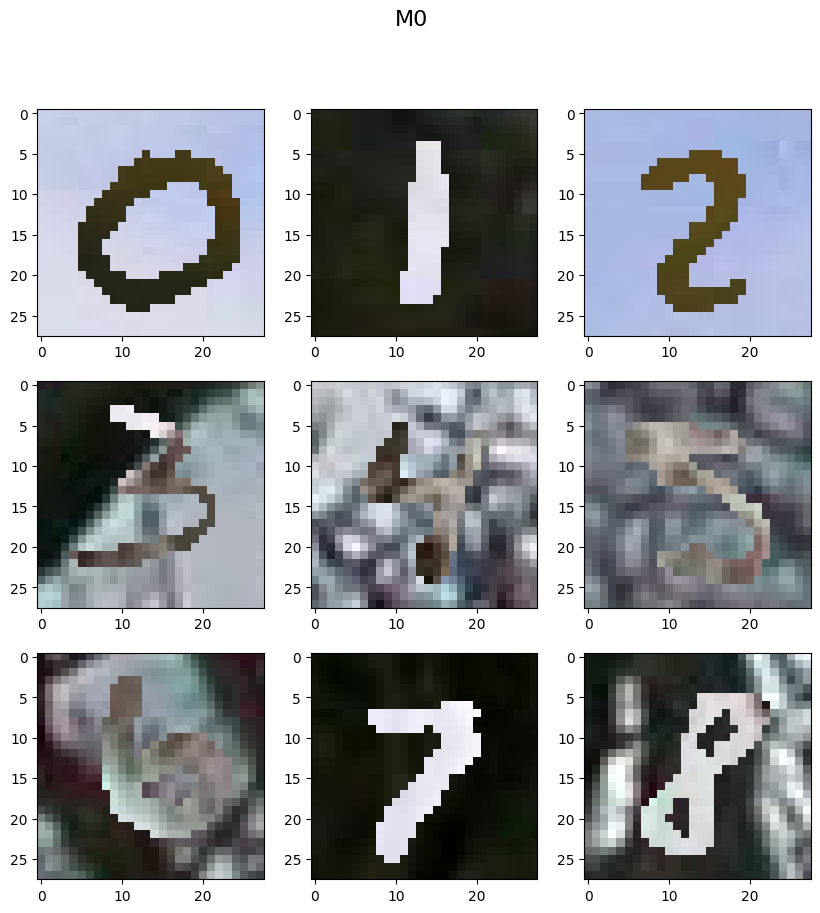

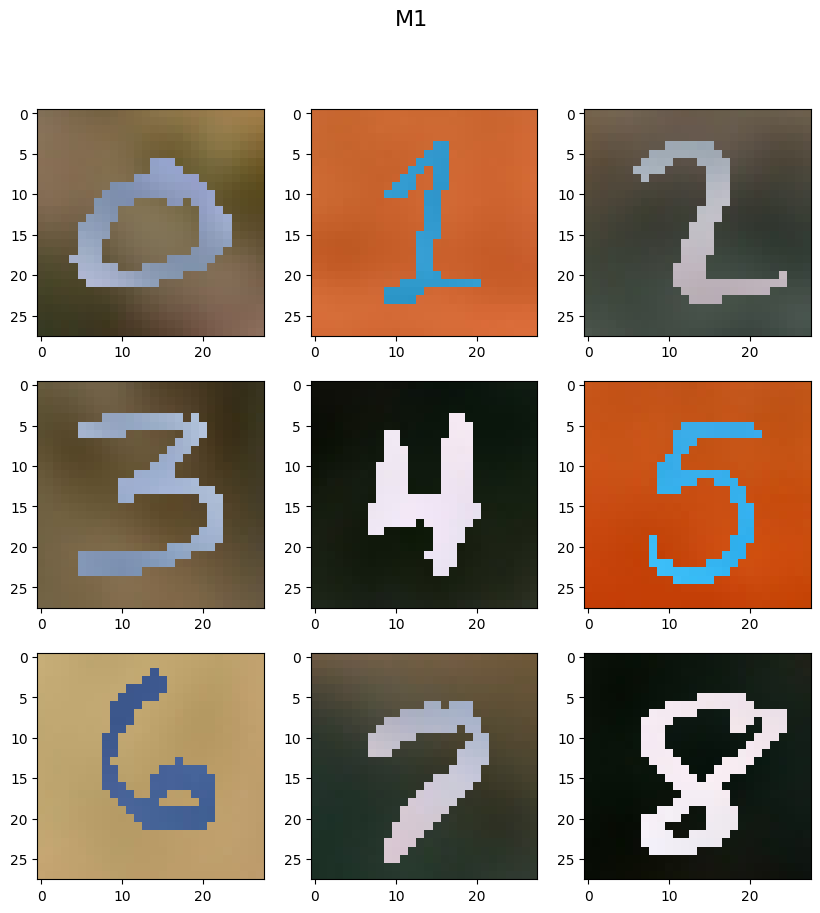

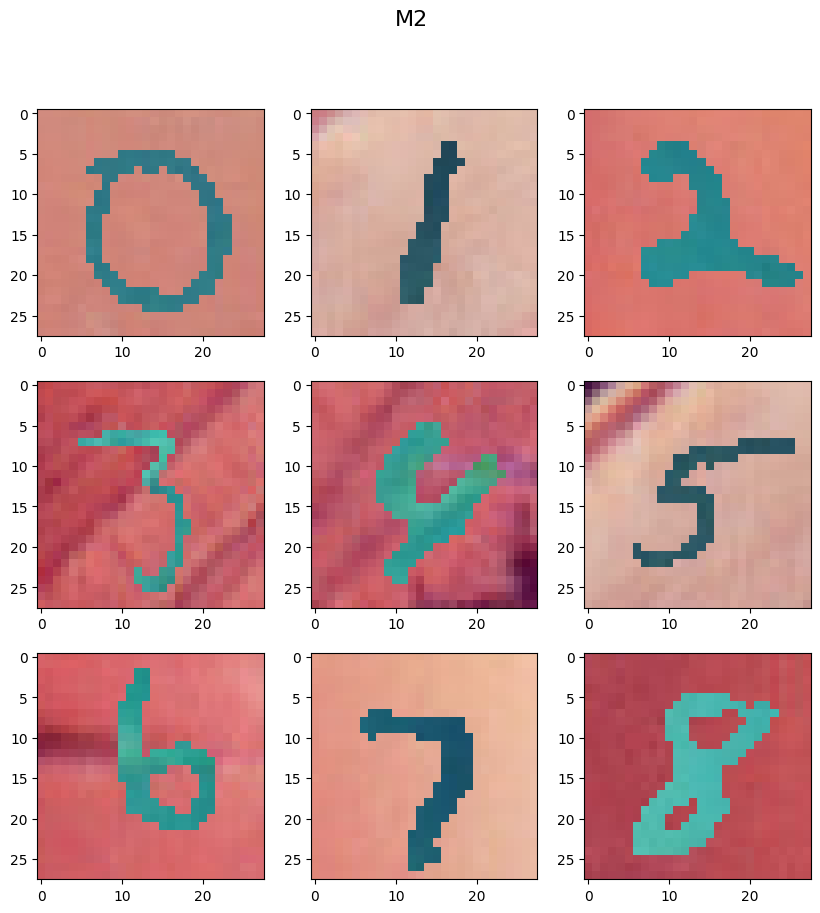

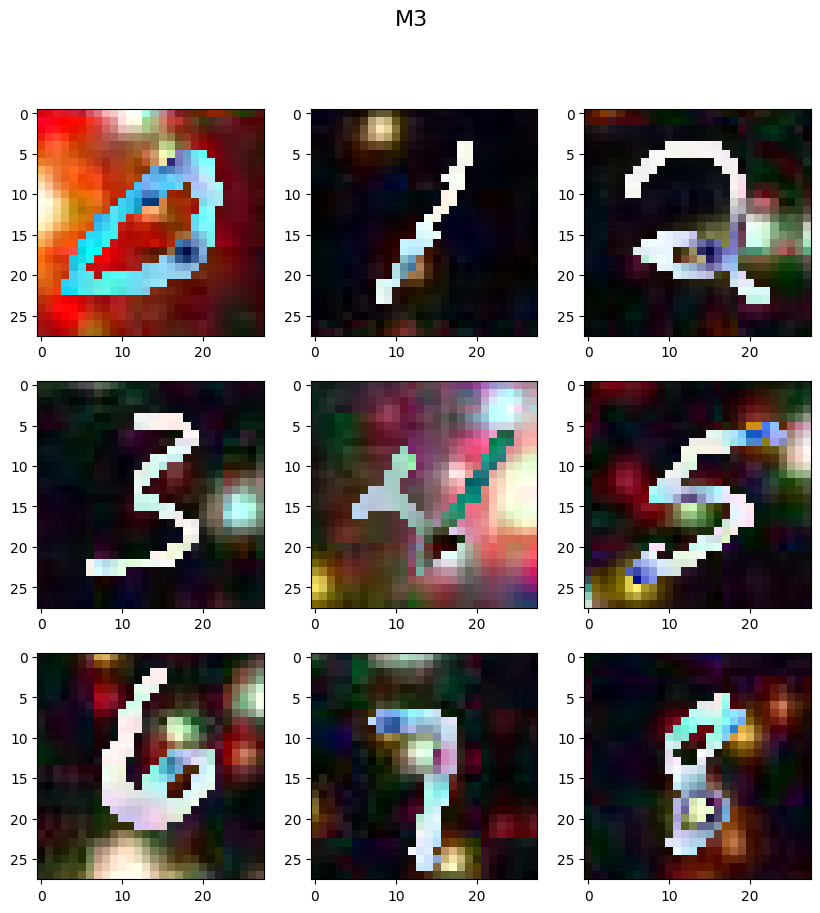

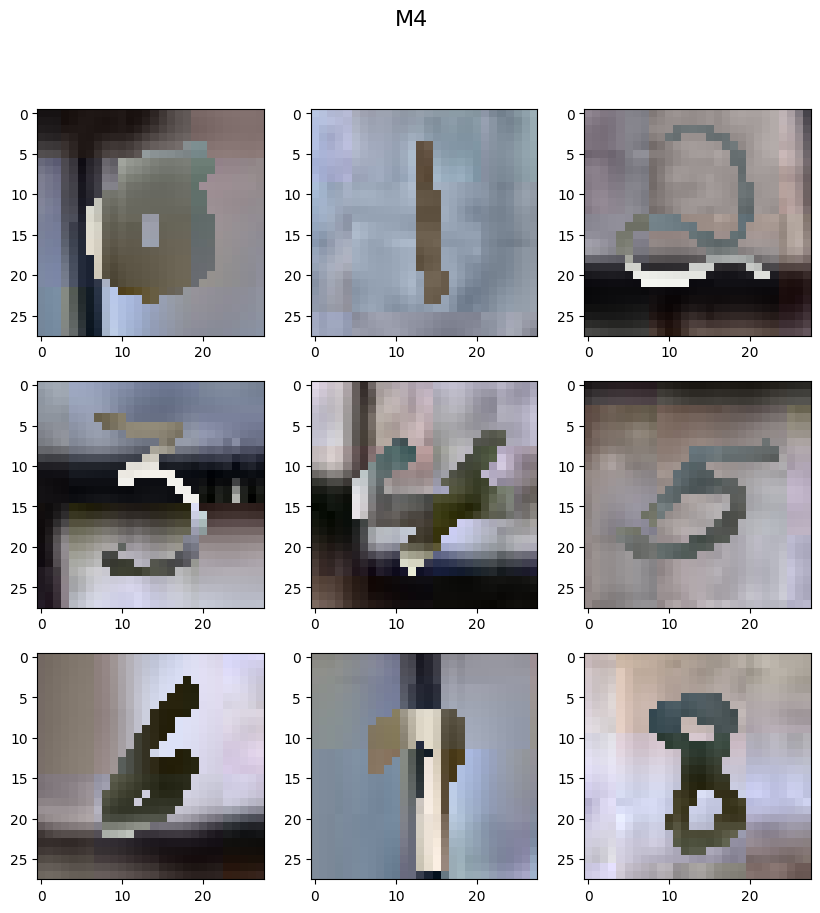

In [ ]:
# Show some images on folder train, 9 for mode
for mode in modes:
  plt.figure(figsize=(10,10))
  # use mode to title
  plt.suptitle(mode.upper(), fontsize=16)
  for i in range(9):
    plt.subplot(330+1+i)
    filename = folder_train + mode + "/0." + str(i) + ".png"
    img = imread(filename)
    plt.imshow(img)
  plt.show()


### Ejercicio 2
Haga un análisis exploratorio de los datos para entenderlos mejor, documente todos los análisis. Especifique la resolución de las imágenes, la distribución del conjunto de datos, si está balanceado o no, etc.

Distribución de resoluciones de imágenes:
          width    height
count  300000.0  300000.0
mean       28.0      28.0
std         0.0       0.0
min        28.0      28.0
25%        28.0      28.0
50%        28.0      28.0
75%        28.0      28.0
max        28.0      28.0

Distribución de imágenes por carpeta:
folder
m0    60000
m1    60000
m2    60000
m3    60000
m4    60000
Name: count, dtype: int64


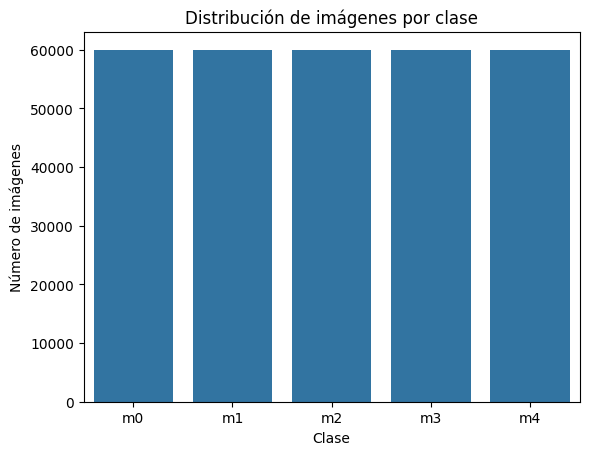

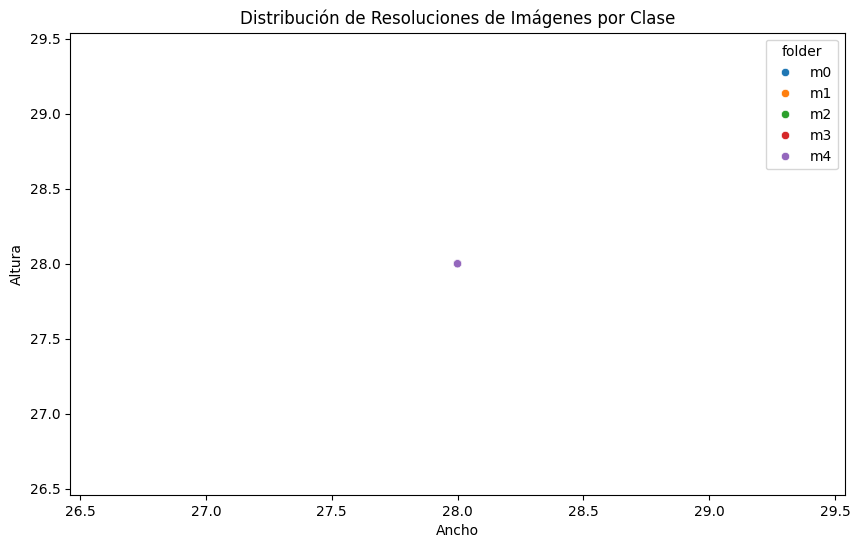

El conjunto de datos está balanceado.


In [ ]:
import seaborn as sns
import cv2
# Inicializar listas para almacenar datos
image_data = []

# Recorrer cada carpeta y analizar las imágenes
for mode in modes:
    folder_path = os.path.join(folder_train, mode)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            height, width, _ = img.shape
            image_data.append({
                'folder': mode,
                'filename': img_name,
                'width': width,
                'height': height
            })

# Convertir los datos a un DataFrame de pandas
df = pd.DataFrame(image_data)

# Documentar la resolución de las imágenes
print("Distribución de resoluciones de imágenes:")
print(df[['width', 'height']].describe())

# Verificar si las imágenes están balanceadas
folder_counts = df['folder'].value_counts()
print("\nDistribución de imágenes por carpeta:")
print(folder_counts)

# Visualizar la distribución de las imágenes por carpeta
sns.barplot(x=folder_counts.index, y=folder_counts.values)
plt.title('Distribución de imágenes por clase')
plt.xlabel('Clase')
plt.ylabel('Número de imágenes')
plt.show()

# Visualizar la distribución de las resoluciones de las imágenes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='width', y='height', hue='folder')
plt.title('Distribución de Resoluciones de Imágenes por Clase')
plt.xlabel('Ancho')
plt.ylabel('Altura')
plt.show()

# Verificar si el conjunto de datos está balanceado
if folder_counts.std() == 0:
    print("El conjunto de datos está balanceado.")
else:
    print("El conjunto de datos NO está balanceado.")

Hasta este momento, se puede observar que las imágenes poseen una calidad aceptable, aunque en algunos ejemplares no se detecta del todo la diferencia entre números, lo cual se verá con mayor detalle posteriormente. De igual forma, se puede apreciar en la gráfica de arriba que todas las categorías de imágenes poseen la misma cantidad de elementos, lo cual lleva a la conclusión que el conjunto de datos está balanceado.

### Ejercicio 3
Haga al menos 2 modelos de Deep learning, determine la efectividad de cada uno y seleccione el mejor de ellos.

#### Primer modelo

In [5]:
folder = "./data/"

# Subdirectorios para entrenamiento y prueba
subdirs = ['train/', 'test/']

original_labelDirs = ['m0/', 'm1/', 'm2/', 'm3/', 'm4/']

# Subdirectorios que corresponden a las clases (m0, m1, m2, m3, m4... m9)
labeldirs = ['m0/', 'm1/', 'm2/', 'm3/', 'm4/', 'm5/', 'm6/', 'm7/', 'm8/', 'm9/']

In [6]:


# Delete folder and content
if os.path.exists(folder):
  shutil.rmtree(folder)

# Create folder
for subdir in subdirs:
  os.makedirs(folder + subdir)


for subdir in subdirs:
    for labeldir in original_labelDirs:
      path = datadir + subdir + labeldir
      if not os.path.exists(path):
        continue
      for file in os.listdir(path):
        number = file.split('.')[1]
        if not os.path.exists(folder + subdir + f"m{number}/"):
          os.makedirs(folder + subdir + f"m{number}")

        try:
          # Rename file
          os.rename(path + file, folder + subdir + f"m{number}/"+ labeldir[:-1]+"_" + file)
        except Exception as e:
          print(f"Error al mover el archivo {file}: {e}")





In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow import keras
import cv2
from skimage.io import imread
from skimage.color import rgb2gray

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('No se encontró GPU. Por favor, activa la GPU en Colab.')
print('GPU encontrada en:', device_name)

binary_label_map = {
    'm0/': 0,
    'm1/': 1,
    'm2/': 2,
    'm3/': 3,
    'm4/': 4,
    'm5/': 5,
    'm6/': 6,
    'm7/': 7,
    'm8/': 8,
    'm9/': 9
}

class ImageDataGenerator(Sequence):
    def __init__(self, directory, labeldirs, label_map, batch_size=16, target_size=(128, 128), shuffle=True):
        self.directory = directory
        self.labeldirs = labeldirs
        self.label_map = label_map
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_paths, self.labels = self._load_image_paths_and_labels()
        self.on_epoch_end()

    def _load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for dir in self.labeldirs:
            dir_path = os.path.join(self.directory, dir)
            for file in os.listdir(dir_path):
                img_path = os.path.join(dir_path, file)
                image_paths.append(img_path)
                labels.append(self.label_map[dir])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for img_path in batch_image_paths:
            img = imread(img_path)
            img_gray = rgb2gray(img)
            processed_img_resized = cv2.resize(img_gray.astype(np.float32), self.target_size, interpolation=cv2.INTER_AREA)
            if len(processed_img_resized.shape) == 2:
                processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)
            images.append(processed_img_resized)

        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = np.array(self.image_paths)[indices]
            self.labels = np.array(self.labels)[indices]

# Crear instancias del generador de datos
train_generator = ImageDataGenerator(os.path.join(folder, subdirs[0]), labeldirs, binary_label_map, batch_size=16)
test_generator = ImageDataGenerator(os.path.join(folder, subdirs[1]), labeldirs, binary_label_map, batch_size=16)

# Definir el modelo
modelo0 = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo0.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
modelo0.summary()

# Entrenar el modelo
history = modelo0.fit(train_generator, validation_data=test_generator, epochs=3)

import json
history_path = 'history0.json'
model_save_path = 'modelo0.h5'
modelo0.save(model_save_path)
print(f'Modelo guardado en {model_save_path}')

with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f'Historial guardado en {history_path}')


GPU encontrada en: /device:GPU:0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       4,194,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,195,466 (16.00 MB)

 Trainable params: 4,195,466 (16.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18750/18750 ━━━━━━━━━━━━━━━━━━━━ 692s 37ms/step - accuracy: 0.7317 - loss: 0.8621 - val_accuracy: 0.7494 - val_loss: 0.8702
Epoch 2/3
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 555s 27ms/step - accuracy: 0.8393 - loss: 0.5347 - val_accuracy: 0.7999 - val_loss: 0.7194
Epoch 3/3
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 558s 27ms/step - accuracy: 0.8604 - loss: 0.4707 - val_accuracy: 0.8480 - val_loss: 0.5616


Modelo guardado en modelo0.h5
Historial guardado en history0.json


In [ ]:
# Cargar el modelo (opcional)
from tensorflow.keras.models import load_model
modelo0 = load_model(model_save_path)
print('Modelo cargado exitosamente.')
# Recompilar el modelo para tener métricas actualizadas
modelo0.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Realizar una evaluación (opcional)
loss, accuracy = modelo0.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

with open(history_path, 'r') as f:
    history0 = json.load(f)

Modelo cargado exitosamente.
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 71s 22ms/step - accuracy: 0.8471 - loss: 0.5634
Pérdida en el conjunto de prueba: 0.5616
Precisión en el conjunto de prueba: 0.8480


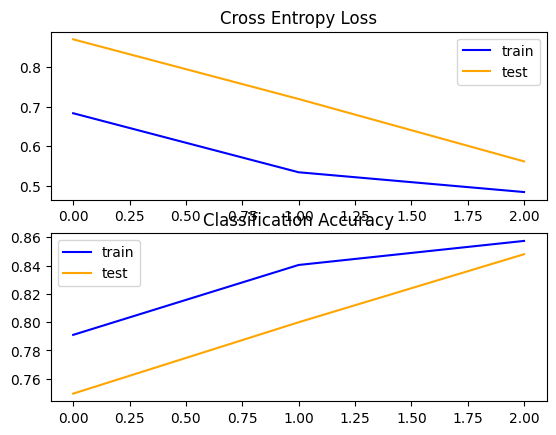

In [ ]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history0['loss'], color='blue', label='train')
plt.plot(history0['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history0['accuracy'], color='blue', label='train')
plt.plot(history0['val_accuracy'], color='orange', label='test')
plt.legend()

plt.show()


Processing directory: ./data/test/m0/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing directory: ./data/test/m1/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Processing directory: ./data/test/m2/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Processing directory: ./data/test/m3/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

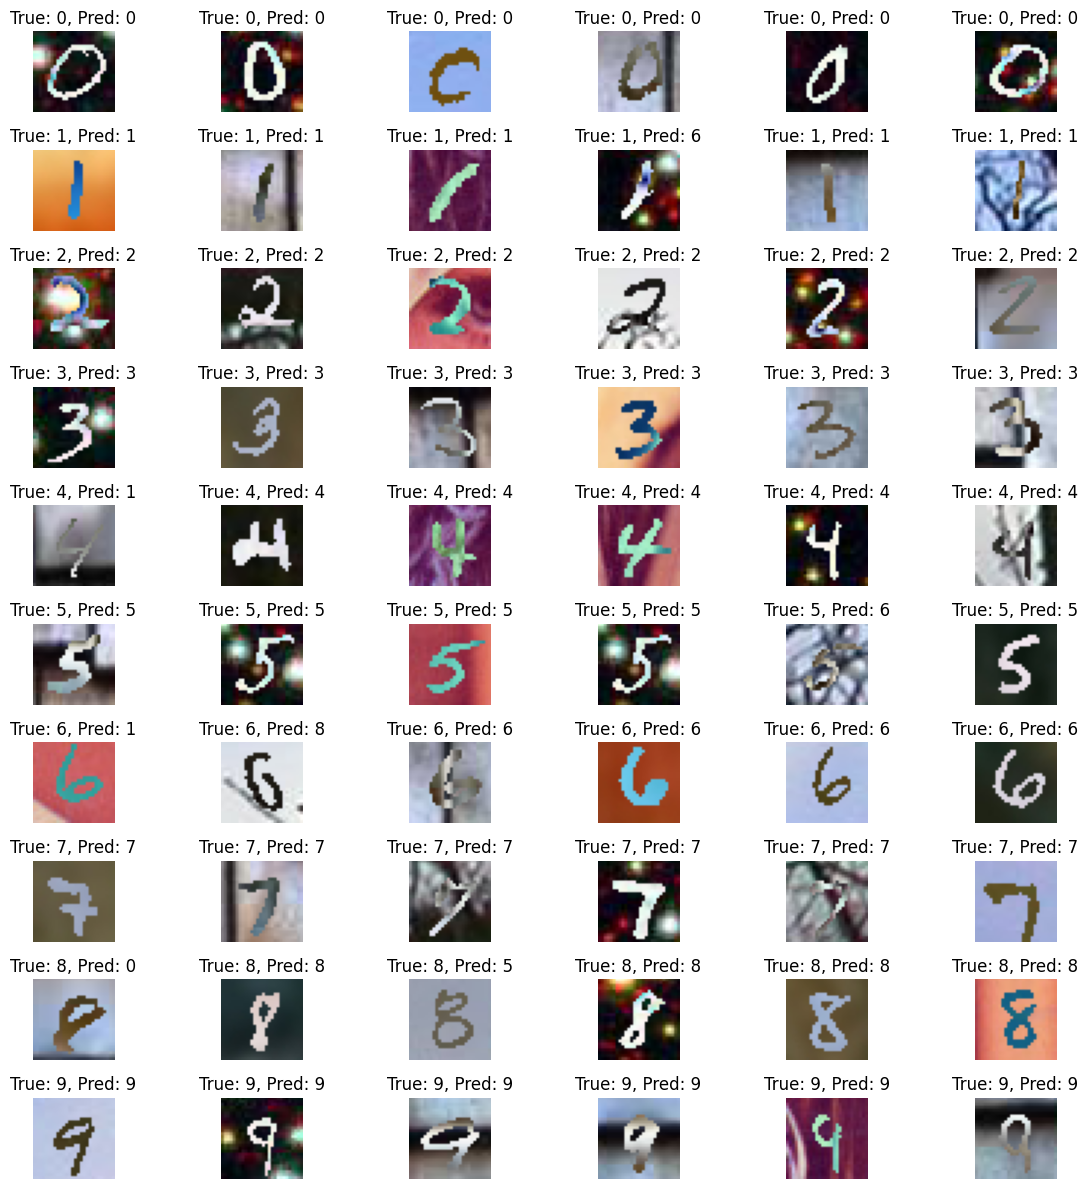

Tested 60 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      1.00      0.92         6
     Class 1       0.71      0.83      0.77         6
     Class 2       1.00      1.00      1.00         6
     Class 3       1.00      1.00      1.00         6
     Class 4       1.00      0.83      0.91         6
     Class 5       0.83      0.83      0.83         6
     Class 6       0.67      0.67      0.67         6
     Class 7       1.00      1.00      1.00         6
     Class 8       0.80      0.67      0.73         6
     Class 9       1.00      1.00      1.00         6

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



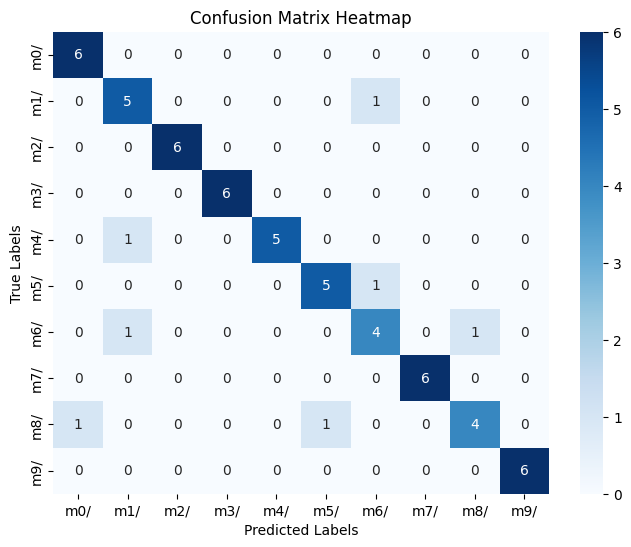

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Función para recortar el centro de la imagen (no es usada en este caso)
def crop_center(img, size):
    y, x = img.shape[:2]
    startx = x // 2 - (size // 2)
    starty = y // 2 - (size // 2)
    return img[starty:starty + size, startx:startx + size]

# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(128, 128)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Redimensionar la imagen al tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(img_gray.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después

# Lista de rutas completas a las carpetas de imágenes
directories = [os.path.join(folder, "test", labeldir) for labeldir in labeldirs]

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(directories):
    print(f'Processing directory: {labeldir}')
    for root, dirs, files in os.walk(labeldir):
        # Escoger 6 imágenes aleatorias
        files_random = random.choices(files, k=6)
        for file in files_random:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción con el modelo cargado
                predictions = modelo0.predict(preprocessed_image)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción

# Mostrar las imágenes con sus predicciones
num_images = len(images)
cols = 6  # número de columnas que deseas
rows = (num_images // cols) + int(num_images % cols > 0)  # calcula el número de filas necesario

plt.figure(figsize=(12, 12))
for i, (img_path, true_label, pred_label) in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imread(img_path))
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Processing directory: ./data/test/m0/
Processing directory: ./data/test/m1/
Processing directory: ./data/test/m2/
Processing directory: ./data/test/m3/
Processing directory: ./data/test/m4/
Processing directory: ./data/test/m5/
Processing directory: ./data/test/m6/
Processing directory: ./data/test/m7/
Processing directory: ./data/test/m8/
Processing directory: ./data/test/m9/
Tested 1000 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.91      0.90       100
     Class 1       0.76      0.94      0.84       100
     Class 2       0.89      0.86      0.87       100
     Class 3       0.92      0.85      0.89       100
     Class 4       0.85      0.85      0.85       100
     Class 5       0.84      0.89      0.86       100
     Class 6       0.90      0.84      0.87       100
     Class 7       0.81      0.86      0.83       100
     Class 8       0.81      0.79      0.80       100
     Class 9       0.92      0.76    

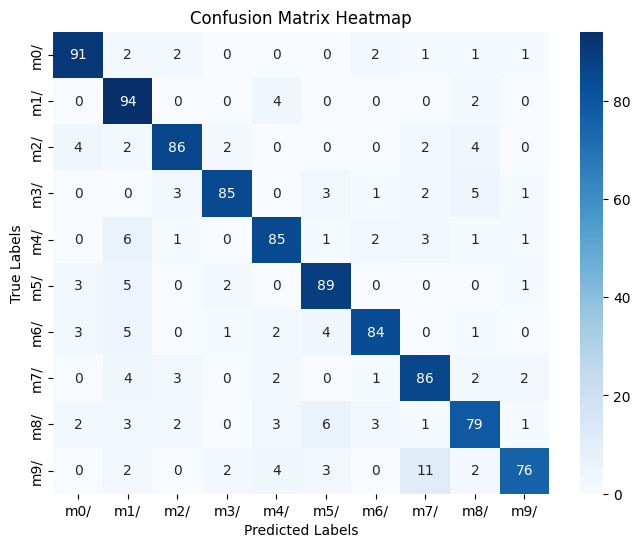

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Función para recortar el centro de la imagen (no es usada en este caso)
def crop_center(img, size):
    y, x = img.shape[:2]
    startx = x // 2 - (size // 2)
    starty = y // 2 - (size // 2)
    return img[starty:starty + size, startx:startx + size]

# Función para preprocesar las imágenes
def preprocess_image(image_path, target_size=(128, 128)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Redimensionar la imagen al tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(img_gray.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después

# Lista de rutas completas a las carpetas de imágenes
directories = [os.path.join(folder, "test", labeldir) for labeldir in labeldirs]

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(directories):
    print(f'Processing directory: {labeldir}')
    for root, dirs, files in os.walk(labeldir):
        # Escoger 6 imágenes aleatorias
        files_random = random.choices(files, k=100)
        for file in files_random:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción con el modelo cargado
                predictions = modelo0.predict(preprocessed_image, verbose=0)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción


# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Luego de observar los resultados en las épocas, modelado en general, accurary (0.8480), pérdida (0.5616) y mapas de correlación, se puede observar que este primer modelo posee un entrenamiento bien formulado y resultados que son exactos, pero sin llegar a casos de overfitting. Los resultados de igual manera comprueban la efectividad a la hora de detectar qué número es cuál. En los mapas de correlación anteriores, se puede observar que los números con menos error son el 0, 1 y 5, a diferencia de valores como el 9 u 8, al ser mayormente confundidos por valores como el 5 o 7 respectivamente.

#### Segundo modelo

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow import keras
import cv2
from skimage.io import imread
from skimage.color import rgb2gray

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('No se encontró GPU. Por favor, activa la GPU en Colab.')
print('GPU encontrada en:', device_name)

# Asignar etiquetas a cada clase
binary_label_map = {
    'm0/': 0,
    'm1/': 1,
    'm2/': 2,
    'm3/': 3,
    'm4/': 4,
    'm5/': 5,
    'm6/': 6,
    'm7/': 7,
    'm8/': 8,
    'm9/': 9
}

class ImageDataGenerator(Sequence):
    def __init__(self, directory, labeldirs, label_map, batch_size=16, target_size=(100, 100), shuffle=True):
        self.directory = directory
        self.labeldirs = labeldirs
        self.label_map = label_map
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_paths, self.labels = self._load_image_paths_and_labels()
        self.on_epoch_end()

    def _load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for dir in self.labeldirs:
            dir_path = os.path.join(self.directory, dir)
            for file in os.listdir(dir_path):
                img_path = os.path.join(dir_path, file)
                image_paths.append(img_path)
                labels.append(self.label_map[dir])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for img_path in batch_image_paths:
            img = imread(img_path)
            img_gray = rgb2gray(img)

            # Redimensionar la imagen a tamaño objetivo
            processed_img_resized = cv2.resize(img_gray.astype(np.float32), self.target_size, interpolation=cv2.INTER_AREA)

            # Asegurar 3 canales (RGB)
            if len(processed_img_resized.shape) == 2:
                processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

            images.append(processed_img_resized)

        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = np.array(self.image_paths)[indices]
            self.labels = np.array(self.labels)[indices]

train_generator = ImageDataGenerator(os.path.join(folder, subdirs[0]), labeldirs, binary_label_map, batch_size=16)
test_generator = ImageDataGenerator(os.path.join(folder, subdirs[1]), labeldirs, binary_label_map, batch_size=16)

# Definir el modelo con Dropout
modelo05 = keras.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(100, 100, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo05.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
modelo05.summary()

# Entrenar el modelo
history = modelo05.fit(train_generator, validation_data=test_generator, epochs=3)

# Guardar el modelo y el historial
import json
history_path = 'history05.json'
model_save_path = 'modelo05.h5'
modelo05.save(model_save_path)
print(f'Modelo guardado en {model_save_path}')

with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f'Historial guardado en {history_path}')


GPU encontrada en: /device:GPU:0


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 100, 100, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 50, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       1,280,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,285,802 (4.90 MB)

 Trainable params: 1,285,802 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 498s 26ms/step - accuracy: 0.7536 - loss: 0.7609 - val_accuracy: 0.9264 - val_loss: 0.2513
Epoch 2/3
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 480s 26ms/step - accuracy: 0.8684 - loss: 0.4370 - val_accuracy: 0.8937 - val_loss: 0.3566
Epoch 3/3
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 479s 26ms/step - accuracy: 0.8575 - loss: 0.4719 - val_accuracy: 0.9090 - val_loss: 0.2980


Modelo guardado en modelo05.h5
Historial guardado en history05.json


In [ ]:
# Cargar el modelo (opcional)
from tensorflow.keras.models import load_model
modelo05 = load_model(model_save_path)
print('Modelo cargado exitosamente.')
# Recompilar el modelo para tener métricas actualizadas
modelo05.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Realizar una evaluación (opcional)
loss, accuracy = modelo05.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

with open(history_path, 'r') as f:
    history0 = json.load(f)

Modelo cargado exitosamente.
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 67s 21ms/step - accuracy: 0.9086 - loss: 0.2991
Pérdida en el conjunto de prueba: 0.2980
Precisión en el conjunto de prueba: 0.9090


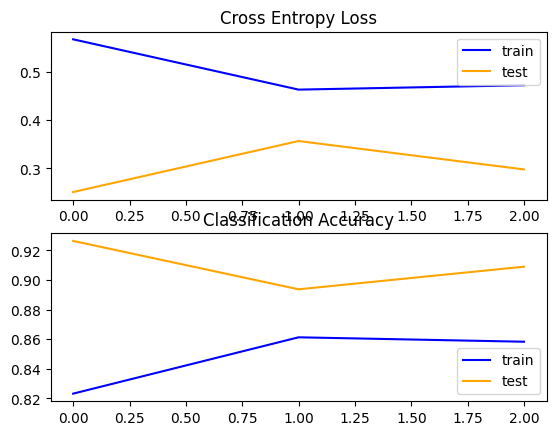

In [ ]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history0['loss'], color='blue', label='train')
plt.plot(history0['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history0['accuracy'], color='blue', label='train')
plt.plot(history0['val_accuracy'], color='orange', label='test')
plt.legend()

plt.show()


In [ ]:
modelo05.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 100, 100, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 50, 50, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       1,280,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,571,606 (9.81 MB)

 Trainable params: 1,285,802 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,285,804 (4.90 MB)

Processing directory: ./data/test/m0/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Processing directory: ./data/test/m1/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Processing directory: ./data/test/m2/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Processing directory: ./data/test/m3/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

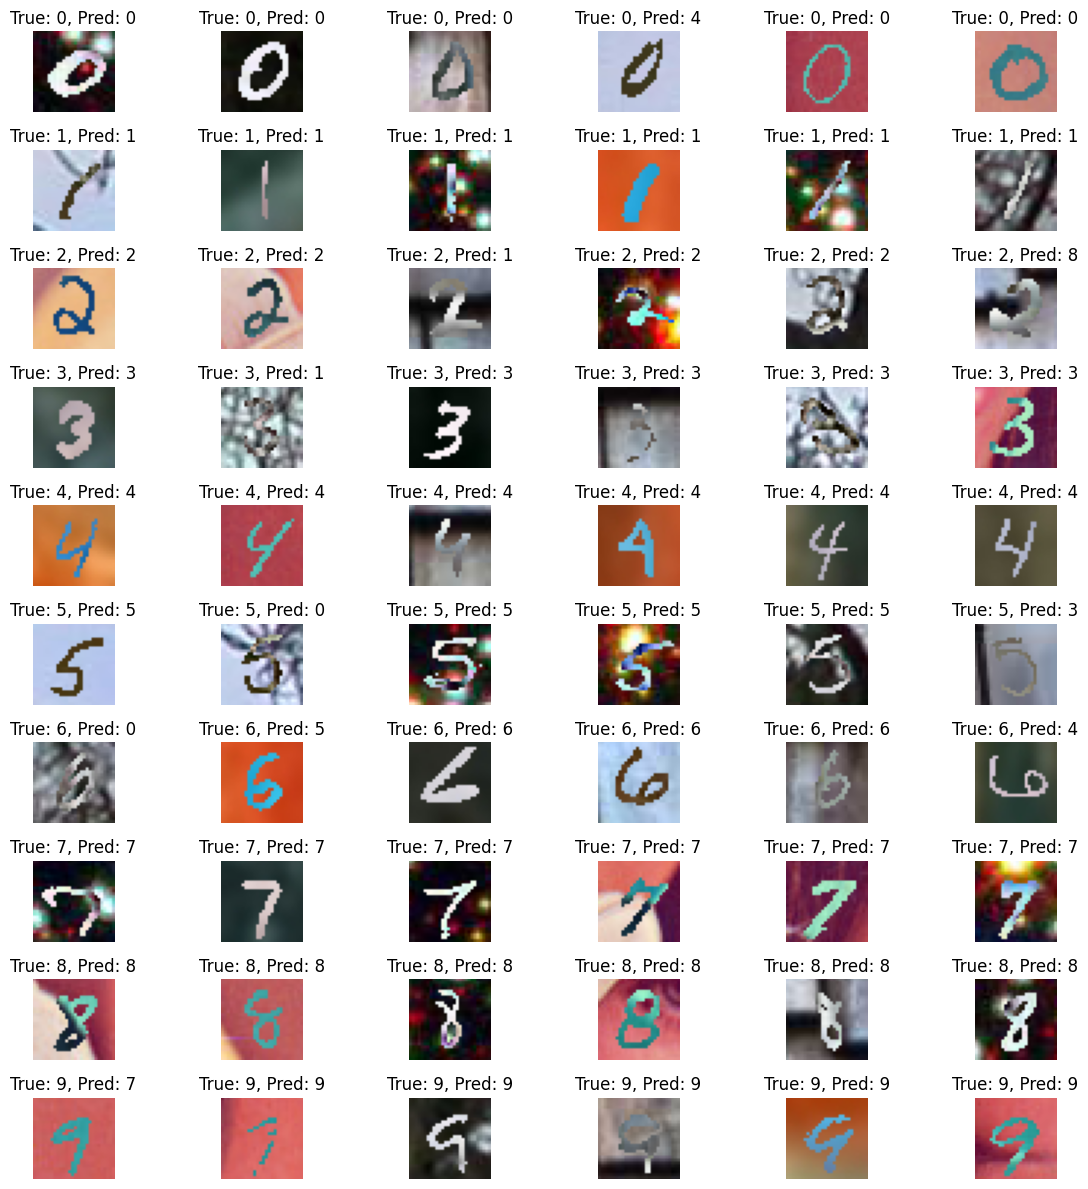

Tested 60 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.83      0.77         6
     Class 1       0.75      1.00      0.86         6
     Class 2       1.00      0.67      0.80         6
     Class 3       0.83      0.83      0.83         6
     Class 4       0.75      1.00      0.86         6
     Class 5       0.80      0.67      0.73         6
     Class 6       1.00      0.50      0.67         6
     Class 7       0.86      1.00      0.92         6
     Class 8       0.86      1.00      0.92         6
     Class 9       1.00      0.83      0.91         6

    accuracy                           0.83        60
   macro avg       0.86      0.83      0.83        60
weighted avg       0.86      0.83      0.83        60

Confusion Matrix:
[[5 0 0 0 1 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 1 4 0 0 0 0 0 1 0]
 [0 1 0 5 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0]
 [1 0 0 1 0 4 0 0 0 0]
 [1 0 0 0 1 1 3 0 0 0]
 [0 0 0 0 0 0 0 6 0 0]

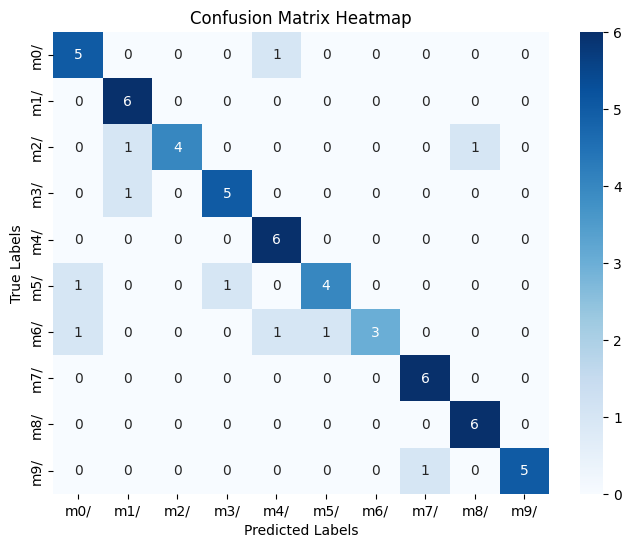

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def preprocess_image(image_path, target_size=(100, 100)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Redimensionar la imagen al tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(img_gray.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized


# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después

# Lista de rutas completas a las carpetas de imágenes
directories = [os.path.join(folder, "test", labeldir) for labeldir in labeldirs]

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(directories):
    print(f'Processing directory: {labeldir}')
    for root, dirs, files in os.walk(labeldir):
        # Escoger 6 imágenes aleatorias
        files_random = random.choices(files, k=6)
        for file in files_random:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción con el modelo cargado
                predictions = modelo05.predict(preprocessed_image)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción

# Mostrar las imágenes con sus predicciones
num_images = len(images)
cols = 6  # número de columnas que deseas
rows = (num_images // cols) + int(num_images % cols > 0)  # calcula el número de filas necesario

plt.figure(figsize=(12, 12))
for i, (img_path, true_label, pred_label) in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imread(img_path))
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Processing directory: ./data/test/m0/
Processing directory: ./data/test/m1/
Processing directory: ./data/test/m3/
Processing directory: ./data/test/m4/
Processing directory: ./data/test/m5/
Processing directory: ./data/test/m6/
Processing directory: ./data/test/m7/
Processing directory: ./data/test/m8/
Processing directory: ./data/test/m9/
Tested 1000 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      0.97      0.93       100
     Class 1       0.89      0.97      0.93       100
     Class 2       0.92      0.84      0.88       100
     Class 3       0.98      0.88      0.93       100
     Class 4       0.91      0.93      0.92       100
     Class 5       0.89      0.92      0.91       100
     Class 6       0.96      0.94      0.95       100
     Class 7       0.94      0.96      0.95       100
     Class 8       0.95      0.86      0.90       100
     Class 9       0.89      0.94      0.91       100

    accuracy        

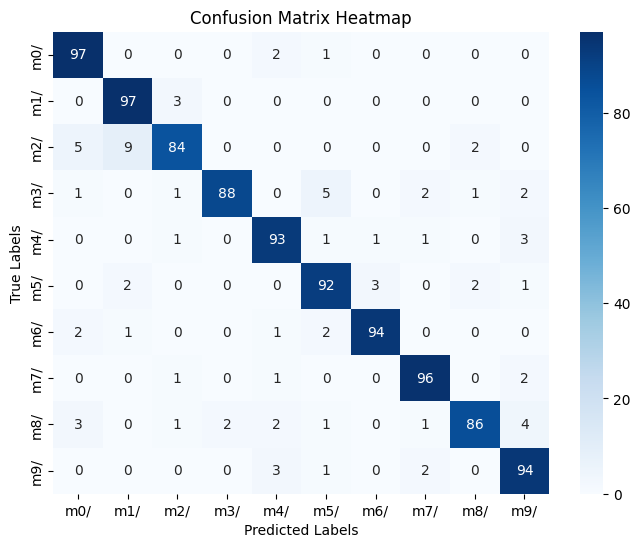

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def preprocess_image(image_path, target_size=(100, 100)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Redimensionar la imagen al tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(img_gray.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized


# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después

# Lista de rutas completas a las carpetas de imágenes
directories = [os.path.join(folder, "test", labeldir) for labeldir in labeldirs]

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(directories):
    print(f'Processing directory: {labeldir}')
    for root, dirs, files in os.walk(labeldir):
        # Escoger 6 imágenes aleatorias
        files_random = random.choices(files, k=100)
        for file in files_random:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción con el modelo cargado
                predictions = modelo05.predict(preprocessed_image, verbose=0)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción



# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Basado en los resultados para este segundo modelo, se puede observar que de igual manera, no llega a valores de overfitting, pero aun así aumenta sus cifras de accuracy (0.9090) y disminuye las de pérdida (0.2980) con respecto al primer modelo presentado. Este cambio y mejora se evidencia igualmente dentro de la pruebas Tru/Predict, donde todos los valores predichos son más altos en relación a los valores verdaderos. En la gráficas de Cross Entropy Loss y Classification Accuracy, se puede observar que ambos conjuntos de entrenamiento y testing se mantienen siempre en valores altos hasta encontrar cierta estabilidad luego de cierto punto crítico en el tiempo. 

Comparando ambos modelos, el primero es más sencillo al poseer solo una capa de convolución seguida de MaxPooling y una capa densa, lo cual lo hace menos profundo y complejo a nivel de capas. Por otro lado, el modelo 2 es más complejo al tener una capa más de convolución y MaxPooling, además de la incorporación de Dropout para reducir el sobreajuste. Estas implementaciones logran mejores resultados y, a pesar de utilizar una escala 100x100 para las imágenes, la arquitectura más robusta y la mayor complejidad logran un mejor desempeño.

Dicho esto, se confirma que el modelo 2 es mejor al modelo 1 en términos de eficiencia, arquitectura, robustez, resultados y análisis de imágenes.

### Modelo de red neuronal simple

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow import keras
import cv2  # OpenCV para redimensionar imágenes
from skimage.io import imread
from skimage.color import rgb2gray
import json

# Verificar GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('No se encontró GPU. Por favor, activa la GPU en Colab.')
print('GPU encontrada en:', device_name)

# Asignar etiquetas a cada clase
binary_label_map = {
    'm0/': 0,
    'm1/': 1,
    'm2/': 2,
    'm3/': 3,
    'm4/': 4,
    'm5/': 5,
    'm6/': 6,
    'm7/': 7,
    'm8/': 8,
    'm9/': 9
}

def crop_center(image, crop_size):
    center = tuple(map(lambda x: x // 2, image.shape))
    half_crop = crop_size // 2
    return image[center[0] - half_crop:center[0] + half_crop,
                 center[1] - half_crop:center[1] + half_crop]

class ImageDataGenerator(Sequence):
    def __init__(self, directory, labeldirs, label_map, batch_size=16, target_size=(100, 100), shuffle=True):
        self.directory = directory
        self.labeldirs = labeldirs
        self.label_map = label_map
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_paths, self.labels = self._load_image_paths_and_labels()
        self.on_epoch_end()

    def _load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for dir in self.labeldirs:
            dir_path = os.path.join(self.directory, dir)
            for file in os.listdir(dir_path):
                img_path = os.path.join(dir_path, file)
                image_paths.append(img_path)
                labels.append(self.label_map[dir])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for img_path in batch_image_paths:
            img = imread(img_path)
            img_gray = rgb2gray(img)

            # Redimensionar la imagen a tamaño objetivo
            processed_img_resized = cv2.resize(img_gray.astype(np.float32), self.target_size, interpolation=cv2.INTER_AREA)

            # Asegurar 3 canales (RGB)
            if len(processed_img_resized.shape) == 2:
                processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

            images.append(processed_img_resized)

        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = np.array(self.image_paths)[indices]
            self.labels = np.array(self.labels)[indices]

# Crear instancias del generador de datos
train_generator = ImageDataGenerator(os.path.join(folder, subdirs[0]), labeldirs, binary_label_map, batch_size=32, target_size=(100, 100))
test_generator = ImageDataGenerator(os.path.join(folder, subdirs[1]), labeldirs, binary_label_map, batch_size=32, target_size=(100, 100))

# Definir el modelo simple
modelo_simple = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100, 3)),  # Aplanar las imágenes
    keras.layers.Dense(128, activation='relu'),  # Capa densa con 128 neuronas
    keras.layers.Dropout(0.5),  # Dropout para evitar el sobreajuste
    keras.layers.Dense(64, activation='relu'),  # Capa densa con 64 neuronas
    keras.layers.Dropout(0.5),  # Dropout adicional
    keras.layers.Dense(10, activation='softmax')  # Capa de salida con 10 neuronas para las 10 clases
])

# Compilar el modelo
modelo_simple.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
modelo_simple.summary()

# Entrenar el modelo
history_simple = modelo_simple.fit(train_generator, validation_data=test_generator, epochs=3)

# Guardar el modelo y el historial
model_save_path_simple = 'modelo_simple.h5'
history_path_simple = 'history_simple.json'

modelo_simple.save(model_save_path_simple)
print(f'Modelo simple guardado en {model_save_path_simple}')

with open(history_path_simple, 'w') as f:
    json.dump(history_simple.history, f)
print(f'Historial del modelo simple guardado en {history_path_simple}')


GPU encontrada en: /device:GPU:0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 30000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,840,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,849,034 (14.68 MB)

 Trainable params: 3,849,034 (14.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9375/9375 ━━━━━━━━━━━━━━━━━━━━ 449s 47ms/step - accuracy: 0.1111 - loss: 2.3683 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 2/3
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 494s 47ms/step - accuracy: 0.1127 - loss: 2.3021 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 3/3
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 438s 47ms/step - accuracy: 0.1126 - loss: 2.3012 - val_accuracy: 0.1135 - val_loss: 2.3012


Modelo simple guardado en modelo_simple.h5
Historial del modelo simple guardado en history_simple.json


In [ ]:
# Cargar el modelo (opcional)
from tensorflow.keras.models import load_model
modelo_simple = load_model(model_save_path_simple)
print('Modelo cargado exitosamente.')
# Recompilar el modelo para tener métricas actualizadas
modelo_simple.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Realizar una evaluación (opcional)
loss, accuracy = modelo_simple.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

with open(history_path_simple, 'r') as f:
    history0 = json.load(f)

Modelo cargado exitosamente.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.1120 - loss: 2.3013
Pérdida en el conjunto de prueba: 2.3012
Precisión en el conjunto de prueba: 0.1135


In [ ]:
import matplotlib.pyplot as plt


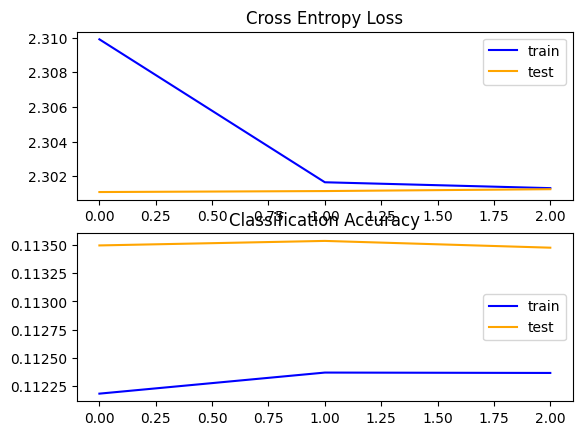

In [ ]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history0['loss'], color='blue', label='train')
plt.plot(history0['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history0['accuracy'], color='blue', label='train')
plt.plot(history0['val_accuracy'], color='orange', label='test')
plt.legend()

plt.show()


In [ ]:
modelo_simple.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 30000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,840,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,849,034 (14.68 MB)

 Trainable params: 3,849,034 (14.68 MB)

 Non-trainable params: 0 (0.00 B)

Processing directory: ./data/test/m0/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Processing directory: ./data/test/m1/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Processing directory: ./data/test/m2/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Processing directory: ./data/test/m3/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

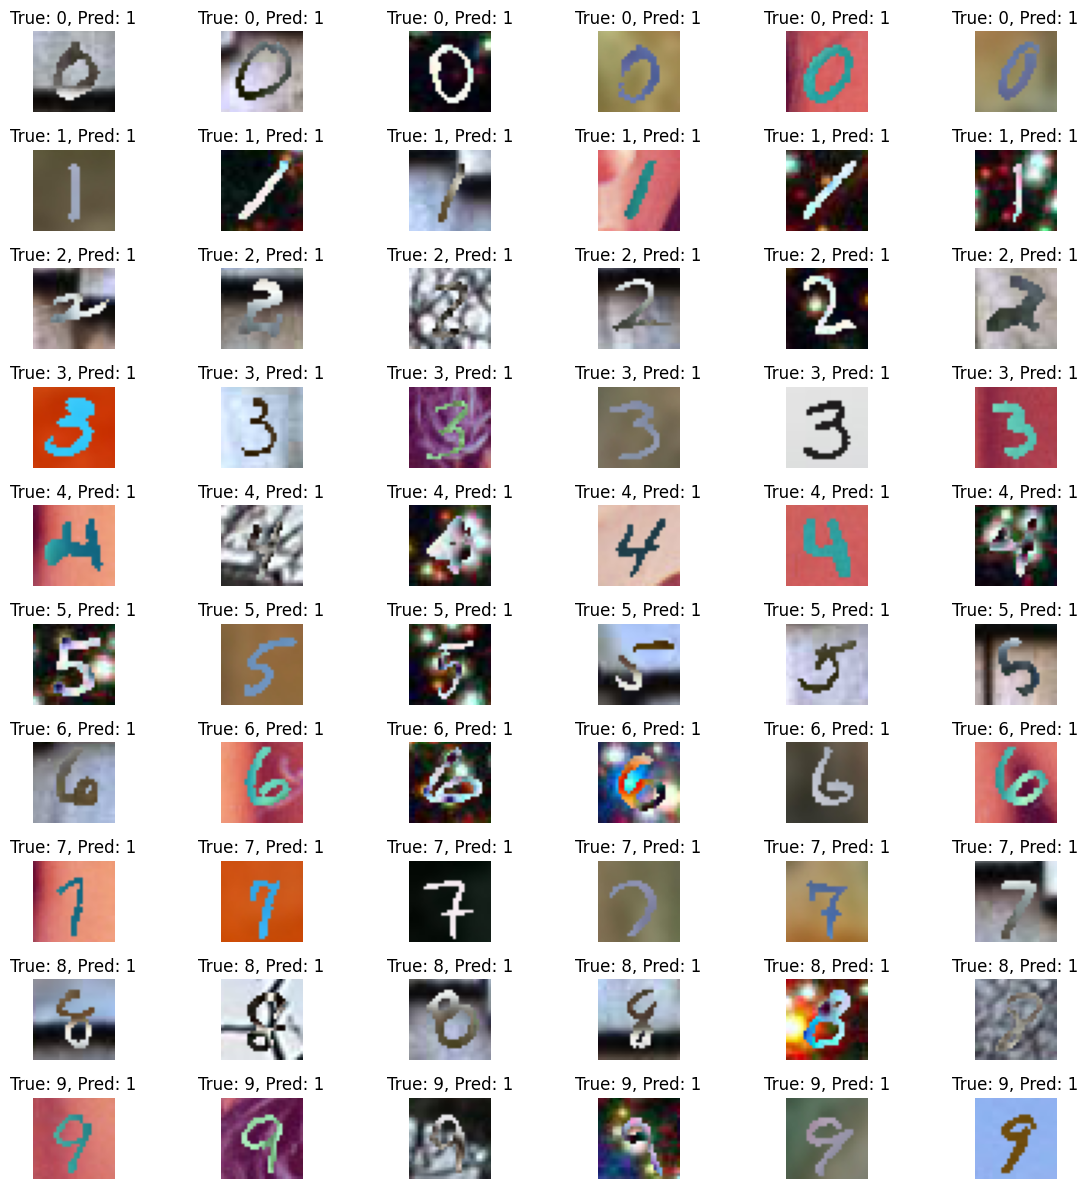

Tested 60 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         6
     Class 1       0.10      1.00      0.18         6
     Class 2       0.00      0.00      0.00         6
     Class 3       0.00      0.00      0.00         6
     Class 4       0.00      0.00      0.00         6
     Class 5       0.00      0.00      0.00         6
     Class 6       0.00      0.00      0.00         6
     Class 7       0.00      0.00      0.00         6
     Class 8       0.00      0.00      0.00         6
     Class 9       0.00      0.00      0.00         6

    accuracy                           0.10        60
   macro avg       0.01      0.10      0.02        60
weighted avg       0.01      0.10      0.02        60

Confusion Matrix:
[[0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


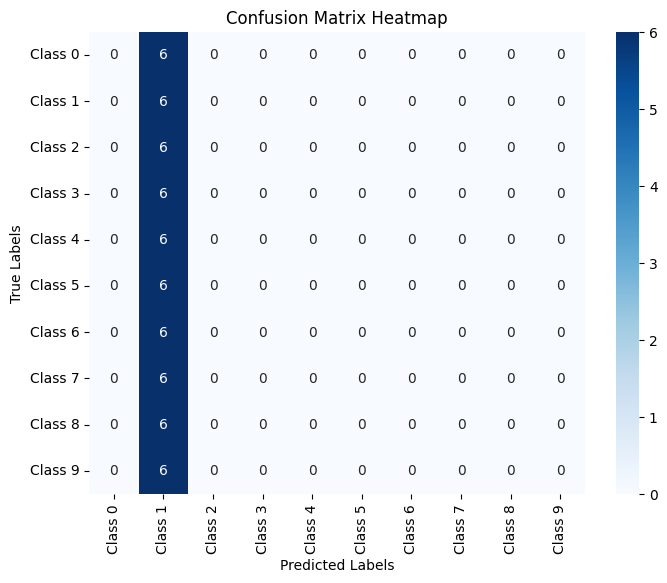

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Ajuste del tamaño objetivo según el generador de datos
TARGET_SIZE = (100, 100)

def preprocess_image(image_path, target_size=TARGET_SIZE):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Redimensionar la imagen a tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(img_gray.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    # Normalizar la imagen
    processed_img_resized /= 255.0

    return processed_img_resized

# Cargar el modelo entrenado
modelo_simple = load_model('modelo_simple.h5')

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después

# Lista de rutas completas a las carpetas de imágenes
directories = [os.path.join(folder, "test", labeldir)  for labeldir in labeldirs]

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(directories):
    print(f'Processing directory: {labeldir}')
    for root, dirs, files in os.walk(labeldir):
        # Escoger 6 imágenes aleatorias
        files_random = random.choices(files, k=6)
        for file in files_random:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción
                predictions = modelo_simple.predict(preprocessed_image)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción

# Mostrar las imágenes con sus predicciones
num_images = len(images)
cols = 6  # número de columnas que deseas
rows = (num_images // cols) + int(num_images % cols > 0)  # calcula el número de filas necesario

plt.figure(figsize=(12, 12))
for i, (img_path, true_label, pred_label) in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imread(img_path))
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(len(labeldirs))], yticklabels=[f'Class {i}' for i in range(len(labeldirs))])

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Processing directory: ./data/test/m0/
Processing directory: ./data/test/m1/
Processing directory: ./data/test/m2/
Processing directory: ./data/test/m3/
Processing directory: ./data/test/m4/
Processing directory: ./data/test/m5/
Processing directory: ./data/test/m6/
Processing directory: ./data/test/m7/
Processing directory: ./data/test/m8/
Processing directory: ./data/test/m9/
Tested 1000 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       100
     Class 1       0.10      1.00      0.18       100
     Class 2       0.00      0.00      0.00       100
     Class 3       0.00      0.00      0.00       100
     Class 4       0.00      0.00      0.00       100
     Class 5       0.00      0.00      0.00       100
     Class 6       0.00      0.00      0.00       100
     Class 7       0.00      0.00      0.00       100
     Class 8       0.00      0.00      0.00       100
     Class 9       0.00      0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


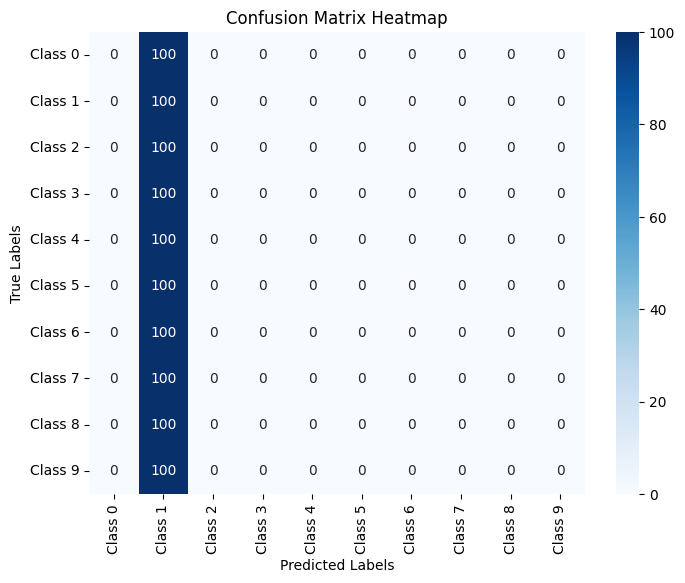

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Ajuste del tamaño objetivo según el generador de datos
TARGET_SIZE = (100, 100)

def preprocess_image(image_path, target_size=TARGET_SIZE):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Redimensionar la imagen a tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(img_gray.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    # Normalizar la imagen
    processed_img_resized /= 255.0

    return processed_img_resized

# Cargar el modelo entrenado
modelo_simple = load_model('modelo_simple.h5')

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después

# Lista de rutas completas a las carpetas de imágenes
directories = [os.path.join(folder, "test", labeldir)  for labeldir in labeldirs]

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(directories):
    print(f'Processing directory: {labeldir}')
    for root, dirs, files in os.walk(labeldir):
        # Escoger 6 imágenes aleatorias
        files_random = random.choices(files, k=100)
        for file in files_random:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción
                predictions = modelo_simple.predict(preprocessed_image, verbose=0)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción



# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(len(labeldirs))], yticklabels=[f'Class {i}' for i in range(len(labeldirs))])

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Entrenamos otro modelo extra

In [ ]:
import os
import numpy as np
from skimage.io import imread
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import joblib  # Para guardar el modelo
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Asignar etiquetas a cada clase
binary_label_map = {
    'm0/': 0,
    'm1/': 1,
    'm2/': 2,
    'm3/': 3,
    'm4/': 4,
    'm5/': 5,
    'm6/': 6,
    'm7/': 7,
    'm8/': 8,
    'm9/': 9
}

def load_data(directory, labeldirs, label_map):
    image_paths = []
    labels = []
    for dir in labeldirs:
        dir_path = os.path.join(directory, dir)
        for file in os.listdir(dir_path):
            img_path = os.path.join(dir_path, file)
            image_paths.append(img_path)
            labels.append(label_map[dir])
    return image_paths, labels

def flatten_image(image_path):
    img = imread(image_path)
    # Aplanar la imagen para XGBoost
    return img.flatten()


train_image_paths, train_labels = load_data(os.path.join(folder, subdirs[0]), labeldirs, binary_label_map)
test_image_paths, test_labels = load_data(os.path.join(folder, subdirs[1]), labeldirs, binary_label_map)

# Cargar imágenes y aplanarlas
X_train = np.array([flatten_image(img_path) for img_path in train_image_paths])
y_train = np.array(train_labels)

X_test = np.array([flatten_image(img_path) for img_path in test_image_paths])
y_test = np.array(test_labels)




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:32:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:32:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:36:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:36:02] WARNING: /workspace/src/common/

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.96      0.94      4900
     Class 1       0.96      0.96      0.96      5675
     Class 2       0.92      0.90      0.91      5160
     Class 3       0.91      0.91      0.91      5050
     Class 4       0.93      0.92      0.92      4910
     Class 5       0.92      0.90      0.91      4460
     Class 6       0.93      0.94      0.94      4790
     Class 7       0.92      0.91      0.92      5140
     Class 8       0.90      0.90      0.90      4870
     Class 9       0.90      0.90      0.90      5045

    accuracy                           0.92     50000
   macro avg       0.92      0.92      0.92     50000
weighted avg       0.92      0.92      0.92     50000

Confusion Matrix:
[[4682    3   28   17   15   33   44    9   56   13]
 [  13 5453   42   32   32    9   29   19   42    4]
 [  58   52 4650  102   40   10   34   85  100   29]
 [  34    3   94 4609    8  111   22   64

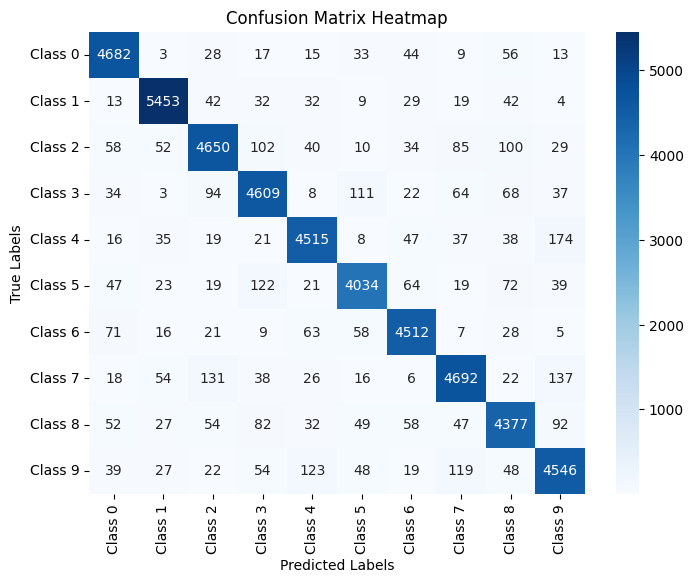

Modelo XGBoost guardado en modelo_xgb.pkl
Historial del modelo XGBoost guardado en history_xgb.json


In [ ]:
# Definir el clasificador XGBoost
model = xgb.XGBClassifier(tree_method='gpu_hist', use_label_encoder=False)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(len(binary_label_map))]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(len(binary_label_map))], yticklabels=[f'Class {i}' for i in range(len(binary_label_map))])

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Guardar el modelo y el historial
model_save_path_xgb = 'modelo_xgb.pkl'
history_path_xgb = 'history_xgb.json'

# Guardar el modelo XGBoost
joblib.dump(model, model_save_path_xgb)
print(f'Modelo XGBoost guardado en {model_save_path_xgb}')

# Guardar el historial de evaluación del modelo
history = {
    'classification_report': classification_report(y_test, y_pred, output_dict=True),
    'confusion_matrix': cm.tolist()
}

with open(history_path_xgb, 'w') as f:
    json.dump(history, f)
print(f'Historial del modelo XGBoost guardado en {history_path_xgb}')

### Modificaciones a la data original.

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


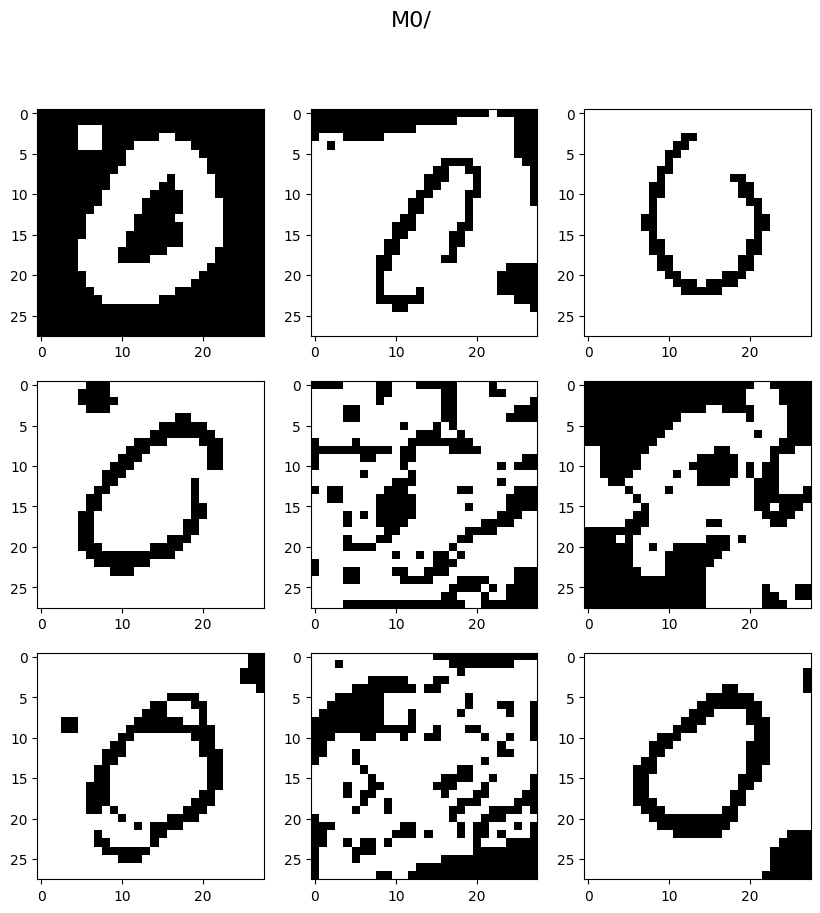

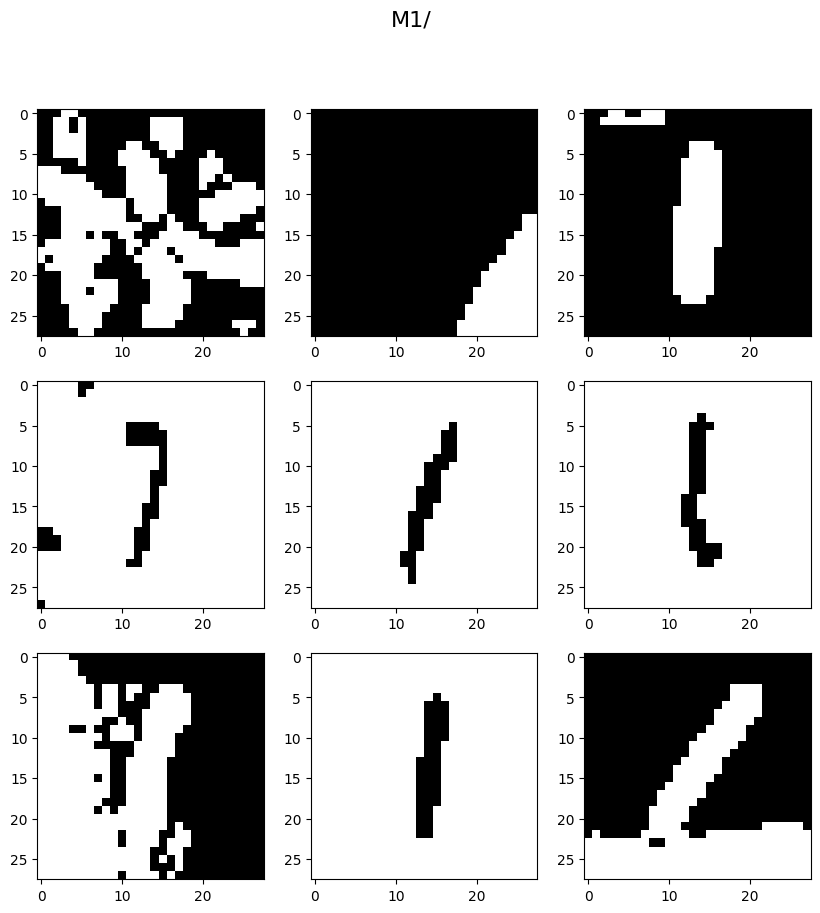

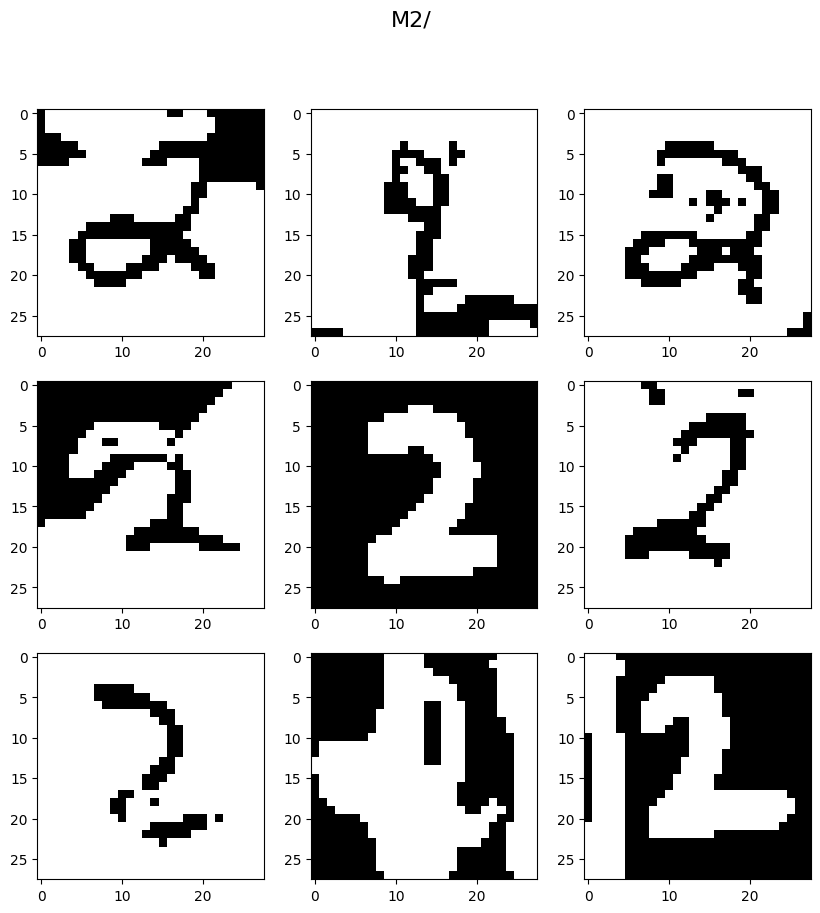

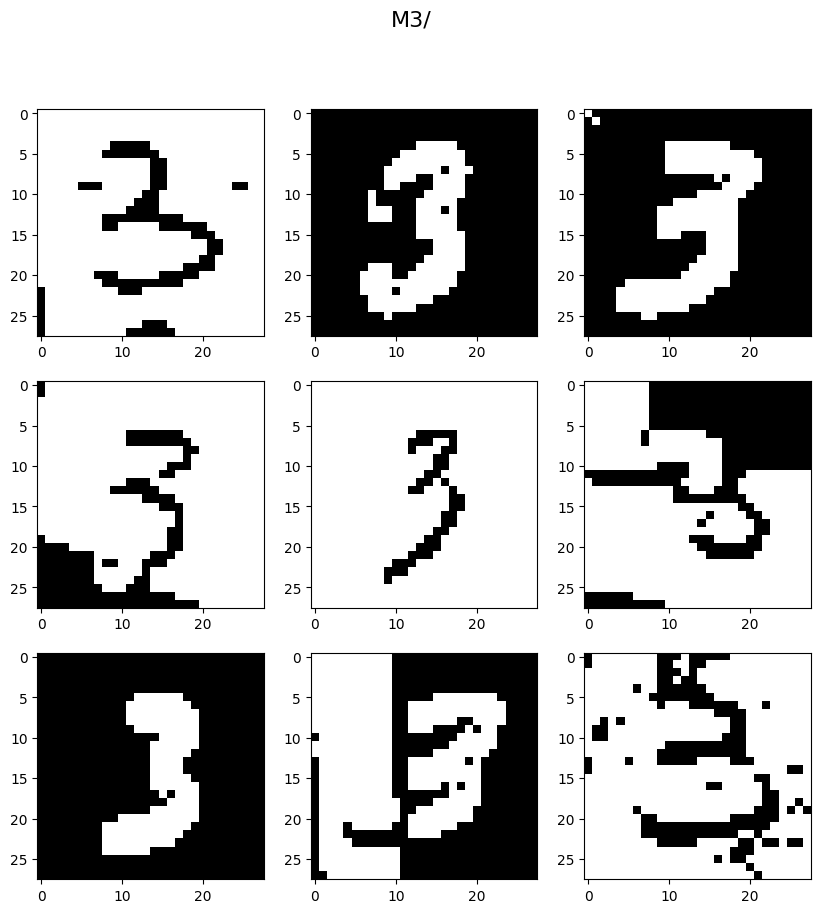

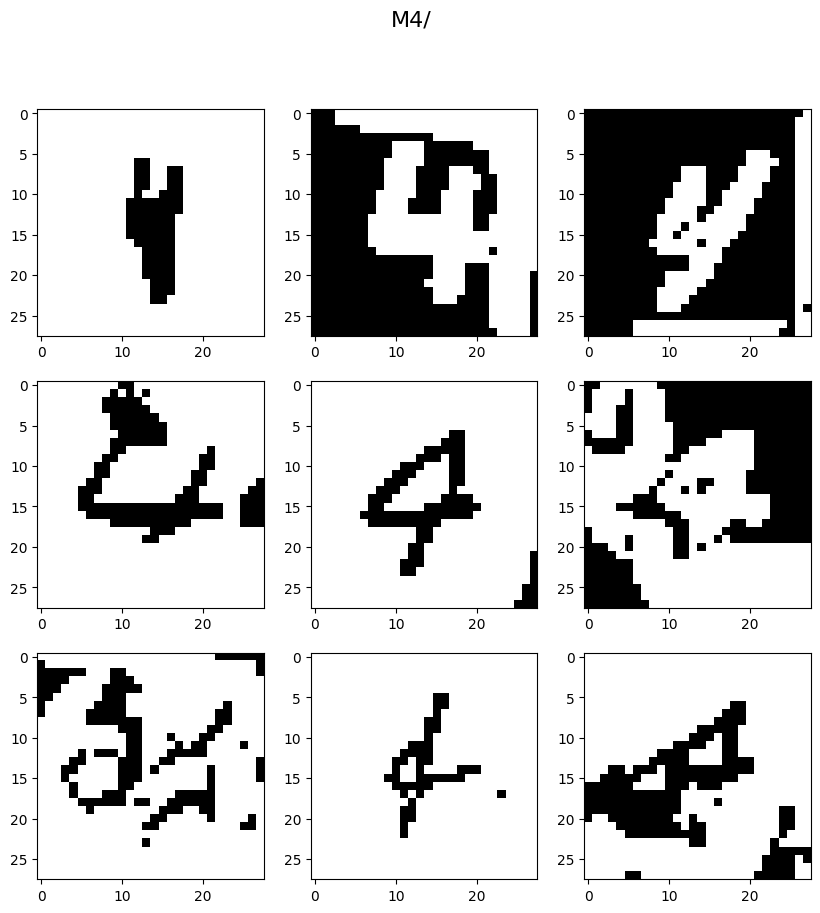

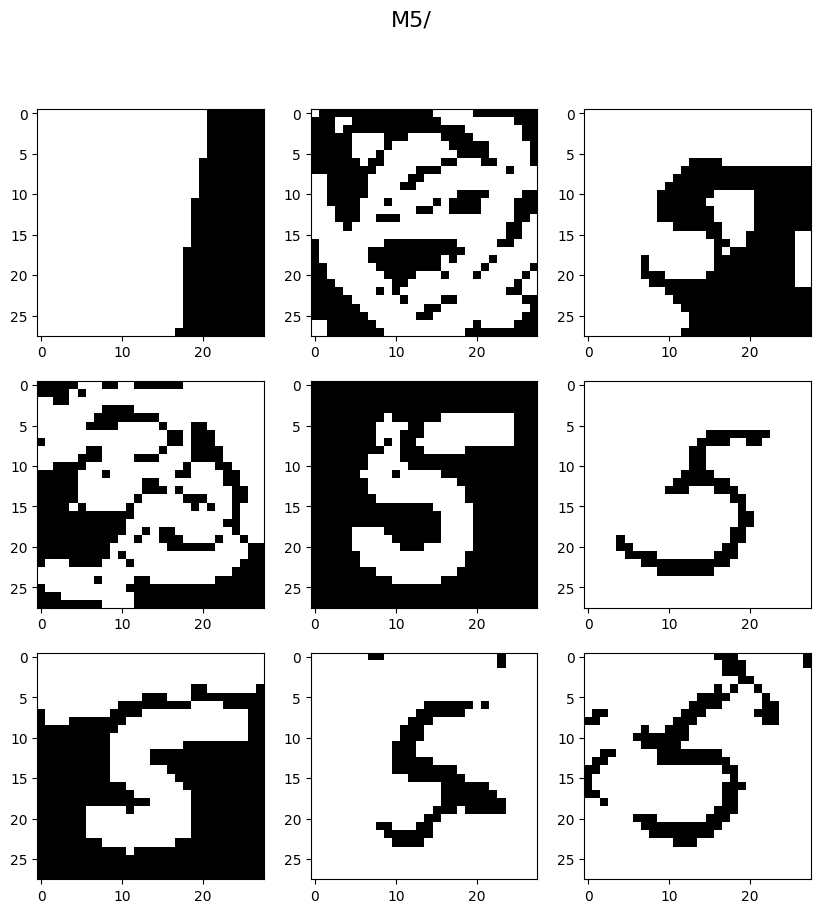

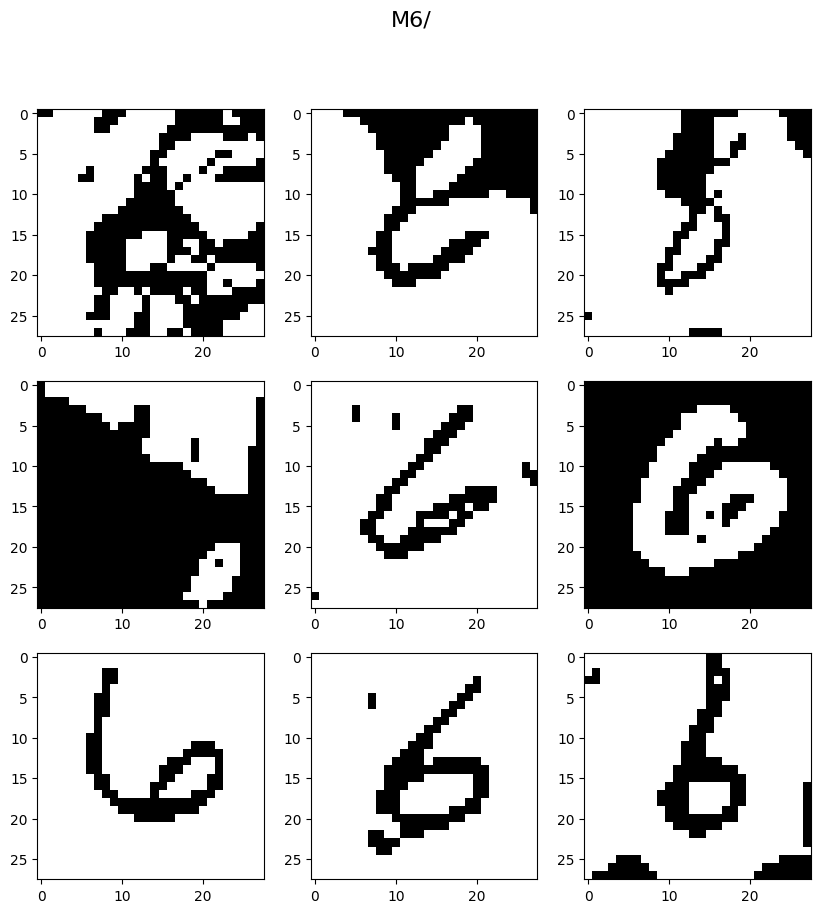

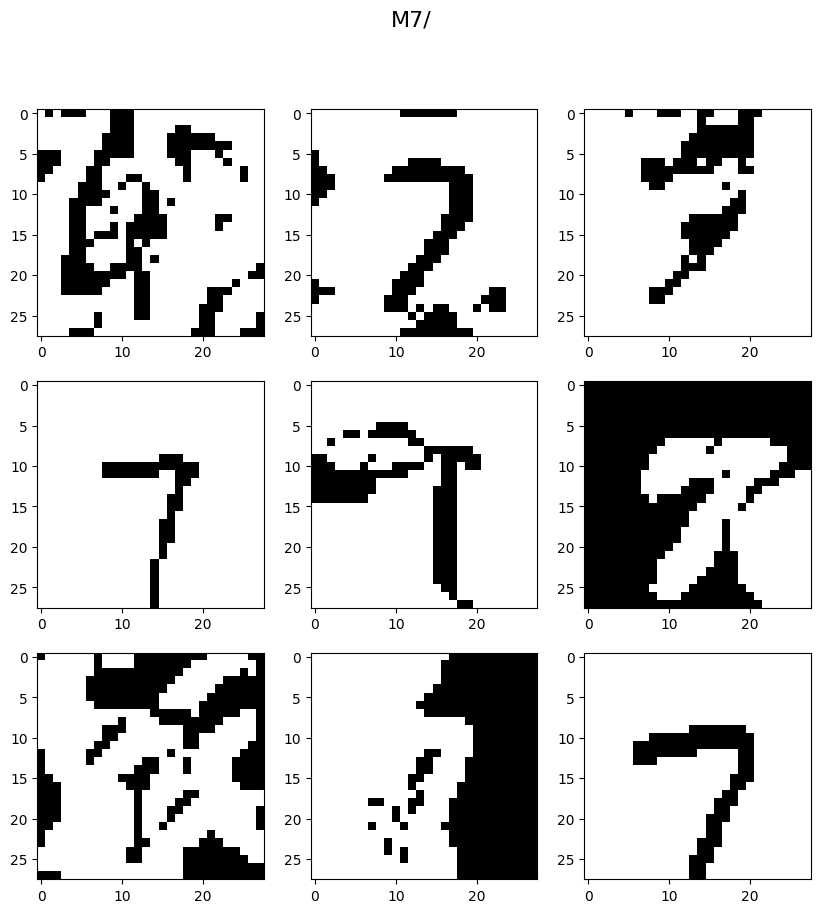

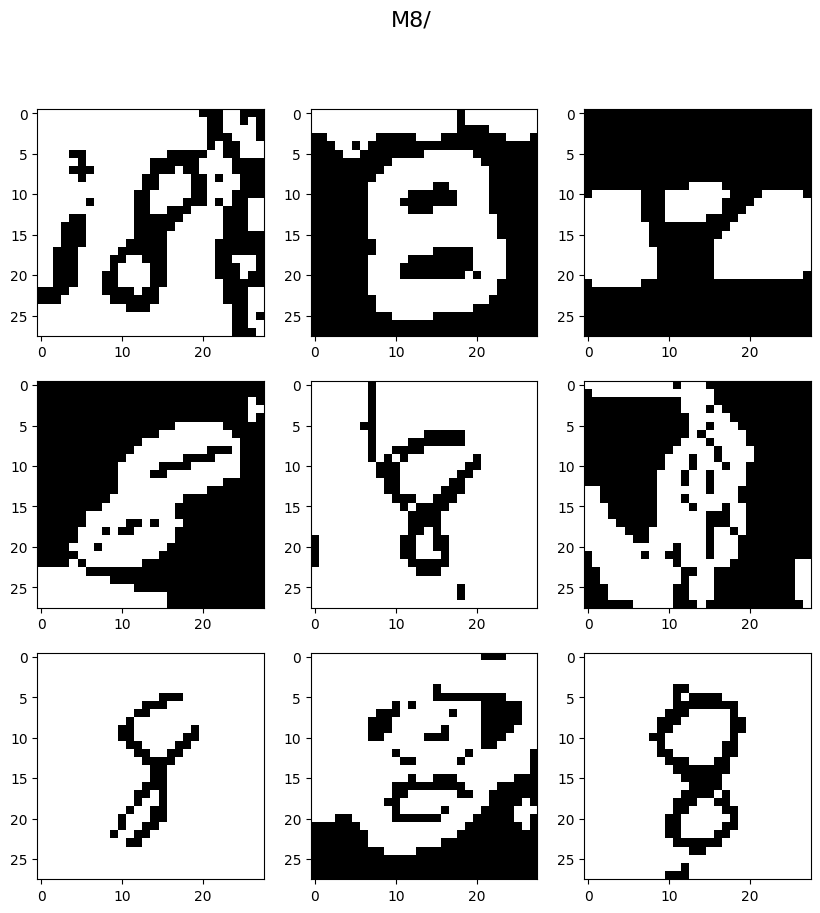

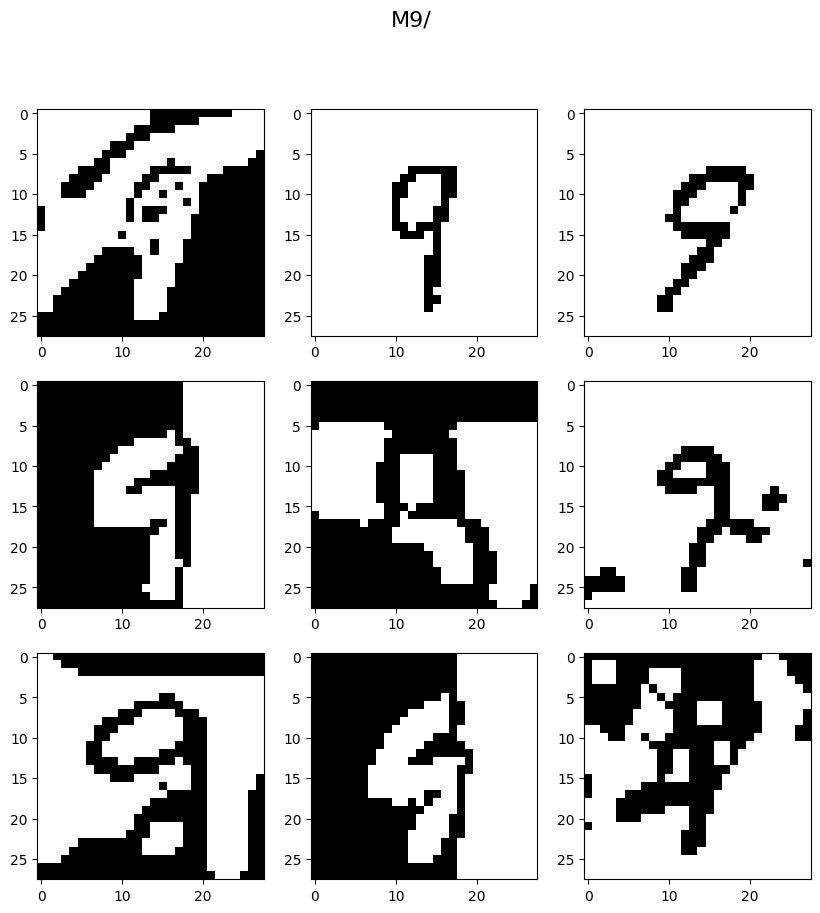

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure


def crop_center(image, crop_size):
    center = tuple(map(lambda x: x // 2, image.shape))
    half_crop = crop_size // 2
    return image[center[0] - half_crop:center[0] + half_crop,
                 center[1] - half_crop:center[1] + half_crop]

for mode in labeldirs:
    plt.figure(figsize=(10, 10))
    plt.suptitle(mode.upper(), fontsize=16)
    path = folder + subdirs[0] + mode
    files = os.listdir(path)
    random.shuffle(files)
    for i in range(9):
        plt.subplot(330 + 1 + i)
        filename = os.path.join(path, files[i])
        img = imread(filename)
        img_gray = rgb2gray(img)  # Convertir a escala de grises

        # Invertir los colores
        img_inverted = 1 - img_gray

        # Aplicar umbral Otsu
        thresh = threshold_otsu(img_inverted)
        binary_img = img_inverted > thresh

        # Aplicar suavizado ligero
        img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

        # Aplicar detección de bordes
        edges = canny(img_smoothed, sigma=1.0)  # Ajustar sigma si es necesario

        # Superponer bordes sobre la imagen binaria
        processed_img = np.clip(binary_img + edges, 0, 1)

        # Realzar el contraste (opcional)
        processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

        # Recortar la imagen al centro
        cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

        # Mostrar la imagen procesada
        plt.imshow(cropped_img, cmap='gray')
    plt.show()


In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow import keras
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from skimage.io import imread
from skimage.color import rgb2gray
import cv2  # OpenCV para redimensionar imágenes

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('No se encontró GPU. Por favor, activa la GPU en Colab.')
print('GPU encontrada en:', device_name)

# Asignar etiquetas a cada clase
binary_label_map = {
    'm0/': 0,
    'm1/': 1,
    'm2/': 2,
    'm3/': 3,
    'm4/': 4,
    'm5/': 5,
    'm6/': 6,
    'm7/': 7,
    'm8/': 8,
    'm9/': 9
}

def crop_center(image, crop_size):
    center = tuple(map(lambda x: x // 2, image.shape))
    half_crop = crop_size // 2
    return image[center[0] - half_crop:center[0] + half_crop,
                 center[1] - half_crop:center[1] + half_crop]

class ImageDataGenerator(Sequence):
    def __init__(self, directory, labeldirs, label_map, batch_size=32, target_size=(200, 200), shuffle=True):
        self.directory = directory
        self.labeldirs = labeldirs
        self.label_map = label_map
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_paths, self.labels = self._load_image_paths_and_labels()
        self.on_epoch_end()

    def _load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for dir in self.labeldirs:
            dir_path = os.path.join(self.directory, dir)
            for file in os.listdir(dir_path):
                img_path = os.path.join(dir_path, file)
                image_paths.append(img_path)
                labels.append(self.label_map[dir])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for img_path in batch_image_paths:
            img = imread(img_path)
            img_gray = rgb2gray(img)  # Convertir a escala de grises

            # Invertir los colores
            img_inverted = 1 - img_gray

            # Aplicar umbral Otsu
            thresh = threshold_otsu(img_inverted)
            binary_img = img_inverted > thresh

            # Aplicar suavizado ligero
            img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

            # Aplicar detección de bordes
            edges = canny(img_smoothed, sigma=1.0)

            # Superponer bordes sobre la imagen binaria
            processed_img = np.clip(binary_img + edges, 0, 1)

            # Realzar el contraste
            processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

            # Recortar la imagen al centro
            cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

            # Redimensionar la imagen a tamaño objetivo usando OpenCV
            processed_img_resized = cv2.resize(cropped_img.astype(np.float32), self.target_size, interpolation=cv2.INTER_AREA)

            # Asegurar que la imagen tenga 3 canales (RGB) y agregar al lote
            if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
                processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

            images.append(processed_img_resized)

        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = np.array(self.image_paths)[indices]
            self.labels = np.array(self.labels)[indices]

# Crear instancias del generador de datos
train_generator = ImageDataGenerator(os.path.join(folder, subdirs[0]), labeldirs, binary_label_map, batch_size=32)
test_generator = ImageDataGenerator(os.path.join(folder, subdirs[1]), labeldirs, binary_label_map, batch_size=32)

# Definir el modelo
modelo1 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
modelo1.summary()

# Entrenar el modelo
history = modelo1.fit(train_generator, validation_data=test_generator, epochs=2)

import json
history_path = 'history1.json'
model_save_path = 'modelo1.h5'
modelo1.save(model_save_path)
print(f'Modelo guardado en {model_save_path}')


with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f'Historial guardado en {history_path}')


GPU encontrada en: /device:GPU:0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      40,960,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,962,314 (156.26 MB)

 Trainable params: 40,962,314 (156.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9375/9375 ━━━━━━━━━━━━━━━━━━━━ 2785s 296ms/step - accuracy: 0.7813 - loss: 0.8651 - val_accuracy: 0.8542 - val_loss: 0.4429
Epoch 2/2
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 2799s 298ms/step - accuracy: 0.8890 - loss: 0.3322 - val_accuracy: 0.8568 - val_loss: 0.4410


Modelo guardado en modelo1.h5
Historial guardado en history1.json


In [ ]:
import json
history_path = 'history1.json'
model_save_path = 'modelo1.h5'

In [ ]:
modelo1.save(model_save_path)
print(f'Modelo guardado en {model_save_path}')


with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f'Historial guardado en {history_path}')


Modelo guardado en modelo1.h5
Historial guardado en history1.json


In [ ]:
# Cargar el modelo (opcional)
from tensorflow.keras.models import load_model
modelo1 = load_model(model_save_path)
print('Modelo cargado exitosamente.')
# Recompilar el modelo para tener métricas actualizadas
modelo1.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Realizar una evaluación (opcional)
loss, accuracy = modelo1.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

with open(history_path, 'r') as f:
    history1 = json.load(f)

Modelo cargado exitosamente.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 395s 252ms/step - accuracy: 0.8547 - loss: 0.4451
Pérdida en el conjunto de prueba: 0.4411
Precisión en el conjunto de prueba: 0.8568


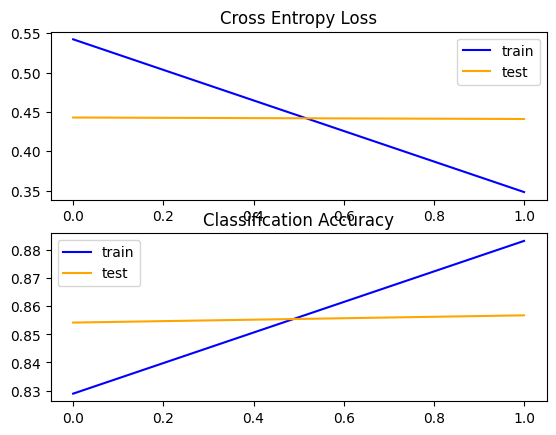

In [ ]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history1['loss'], color='blue', label='train')
plt.plot(history1['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history1['accuracy'], color='blue', label='train')
plt.plot(history1['val_accuracy'], color='orange', label='test')
plt.legend()

plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


['./data/test/m0/', './data/test/m1/', './data/test/m2/', './data/test/m3/', './data/test/m4/', './data/test/m5/', './data/test/m6/', './data/test/m7/', './data/test/m8/', './data/test/m9/']
./data/test/m0/
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
./data/test/m1/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
./data/test/m2/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
./data/test/m3/
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━

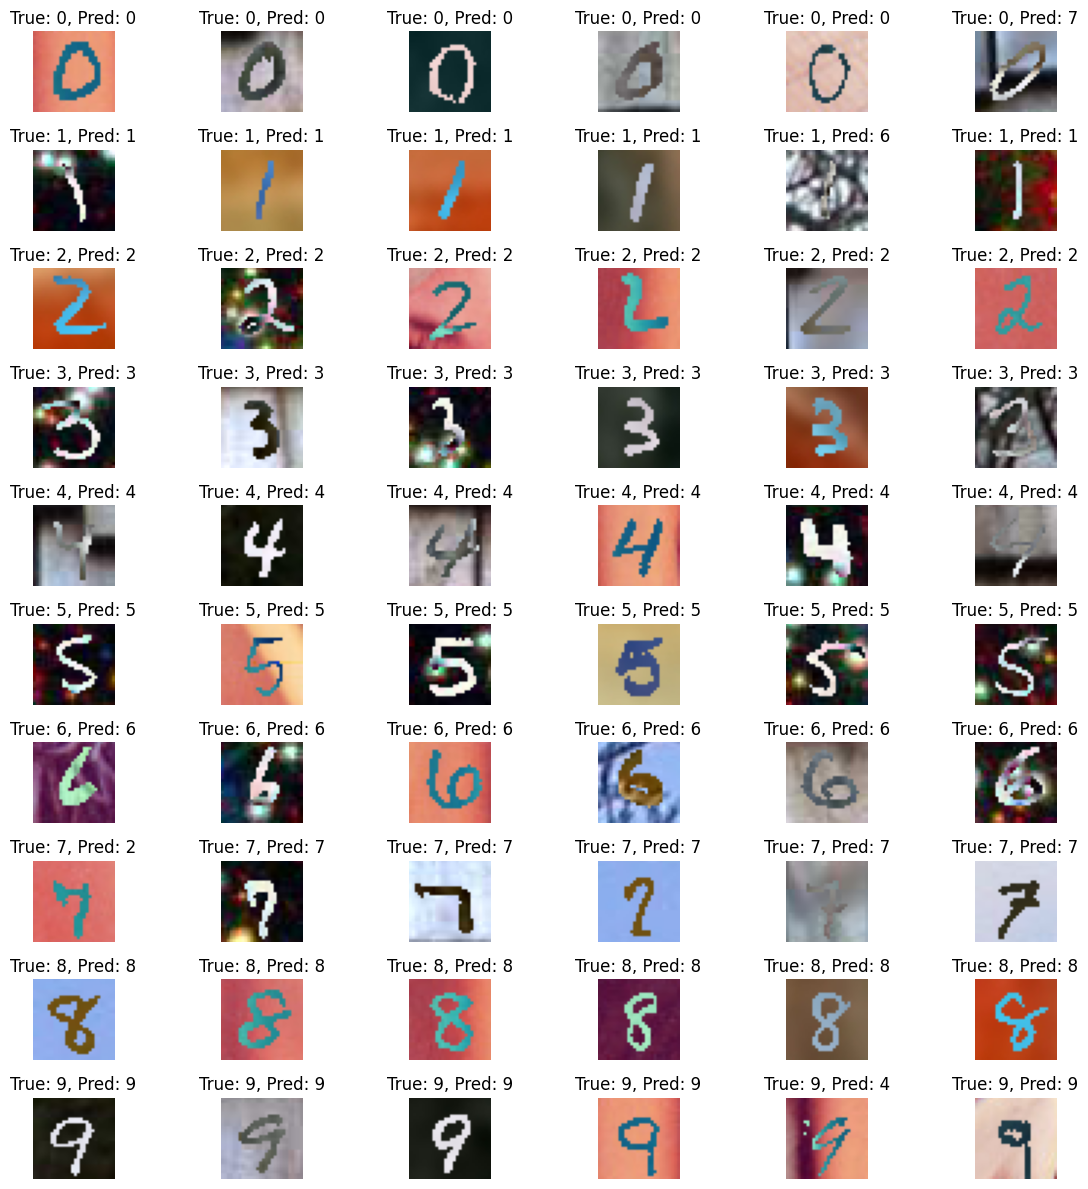

Tested 60 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.83      0.91         6
     Class 1       1.00      0.83      0.91         6
     Class 2       0.86      1.00      0.92         6
     Class 3       1.00      1.00      1.00         6
     Class 4       0.86      1.00      0.92         6
     Class 5       1.00      1.00      1.00         6
     Class 6       0.86      1.00      0.92         6
     Class 7       0.83      0.83      0.83         6
     Class 8       1.00      1.00      1.00         6
     Class 9       1.00      0.83      0.91         6

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

Confusion Matrix:
[[5 0 0 0 0 0 0 1 0 0]
 [0 5 0 0 0 0 1 0 0 0]
 [0 0 6 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 6 0 0 0 0]
 [0 0 0 0 0 0 6 0 0 0]
 [0 0 1 0 0 0 0 5 0 0]

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from sklearn.metrics import classification_report, confusion_matrix

# Cargar el modelo
model_path = './drive/MyDrive/modelo1.h5'
modelo1 = load_model(model_path)

# Lista de directorios que contienen las imágenes etiquetadas

# Función para recortar la imagen al centro
def crop_center(img, size):
    y, x = img.shape[:2]
    startx = x//2 - (size//2)
    starty = y//2 - (size//2)
    return img[starty:starty+size, startx:startx+size]

# Función para preprocesar una imagen de la misma manera que en el generador de datos
def preprocess_image(image_path, target_size=(200, 200)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Recortar la imagen al centro
    cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

    # Redimensionar la imagen a tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(cropped_img.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después


lala = [folder+subdirs[1] + label for label in labeldirs]
print(lala)

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(lala):
    print(labeldir)
    for root, dirs, files in os.walk(labeldir):
        # Escoger 2 imágenes aleatorias
        filesRandom = random.choices(files, k=6)
        for file in filesRandom:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción
                predictions = modelo1.predict(preprocessed_image)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción

# Mostrar las imágenes con sus predicciones
num_images = len(images)
cols = 6  # número de columnas que deseas
rows = (num_images // cols) + int(num_images % cols > 0)  # calcula el número de filas necesario

plt.figure(figsize=(12, 12))
for i, (img_path, true_label, pred_label) in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imread(img_path))
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


['./data/test/m0/', './data/test/m1/', './data/test/m2/', './data/test/m3/', './data/test/m4/', './data/test/m5/', './data/test/m6/', './data/test/m7/', './data/test/m8/', './data/test/m9/']
./data/test/m0/
./data/test/m1/
./data/test/m2/
./data/test/m3/
./data/test/m4/
./data/test/m5/
./data/test/m6/
./data/test/m7/
./data/test/m8/
./data/test/m9/
Tested 1000 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.89      0.88       100
     Class 1       0.80      0.89      0.84       100
     Class 2       0.86      0.79      0.82       100
     Class 3       0.87      0.84      0.85       100
     Class 4       0.81      0.85      0.83       100
     Class 5       0.83      0.80      0.82       100
     Class 6       0.91      0.81      0.86       100
     Class 7       0.84      0.81      0.82       100
     Class 8       0.76      0.90      0.83       100
     Class 9       0.87      0.80      0.83       100

    accurac

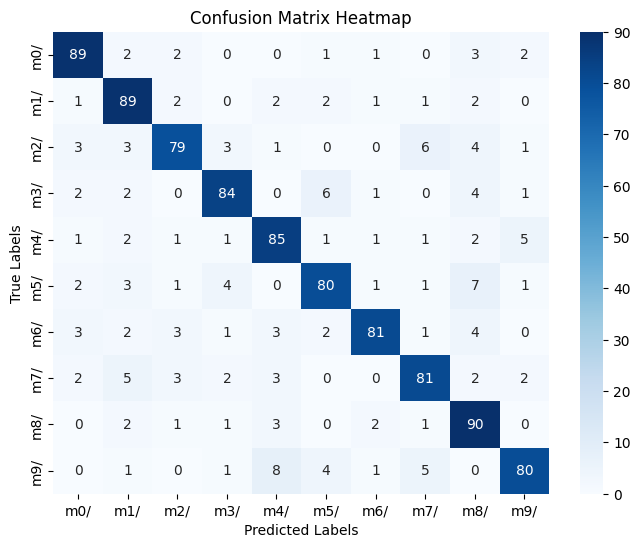

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from sklearn.metrics import classification_report, confusion_matrix

# Lista de directorios que contienen las imágenes etiquetadas
# Cargar el modelo
model_path = './drive/MyDrive/modelo1.h5'
modelo1 = load_model(model_path)

# Función para recortar la imagen al centro
def crop_center(img, size):
    y, x = img.shape[:2]
    startx = x//2 - (size//2)
    starty = y//2 - (size//2)
    return img[starty:starty+size, startx:startx+size]

# Función para preprocesar una imagen de la misma manera que en el generador de datos
def preprocess_image(image_path, target_size=(200, 200)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Recortar la imagen al centro
    cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

    # Redimensionar la imagen a tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(cropped_img.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después


lala = [folder+subdirs[1] + label for label in labeldirs]
print(lala)

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(lala):
    print(labeldir)
    for root, dirs, files in os.walk(labeldir):
        # Escoger 2 imágenes aleatorias
        filesRandom = random.choices(files, k=100)
        for file in filesRandom:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción
                predictions = modelo1.predict(preprocessed_image, verbose=0)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción


# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
srcdir = "./data/"
destinationFolder = "./drive/MyDrive/data"

shutil.copytree(srcdir, destinationFolder)

'./drive/MyDrive/data'

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow import keras
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from skimage.io import imread
from skimage.color import rgb2gray
import cv2  # OpenCV para redimensionar imágenes

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('No se encontró GPU. Por favor, activa la GPU en Colab.')
print('GPU encontrada en:', device_name)

# Asignar etiquetas a cada clase
binary_label_map = {
    'm0/': 0,
    'm1/': 1,
    'm2/': 2,
    'm3/': 3,
    'm4/': 4,
    'm5/': 5,
    'm6/': 6,
    'm7/': 7,
    'm8/': 8,
    'm9/': 9
}

def crop_center(image, crop_size):
    center = tuple(map(lambda x: x // 2, image.shape))
    half_crop = crop_size // 2
    return image[center[0] - half_crop:center[0] + half_crop,
                 center[1] - half_crop:center[1] + half_crop]

class ImageDataGenerator(Sequence):
    def __init__(self, directory, labeldirs, label_map, batch_size=32, target_size=(200, 200), shuffle=True):
        self.directory = directory
        self.labeldirs = labeldirs
        self.label_map = label_map
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_paths, self.labels = self._load_image_paths_and_labels()
        self.on_epoch_end()

    def _load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for dir in self.labeldirs:
            dir_path = os.path.join(self.directory, dir)
            for file in os.listdir(dir_path):
                img_path = os.path.join(dir_path, file)
                image_paths.append(img_path)
                labels.append(self.label_map[dir])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for img_path in batch_image_paths:
            img = imread(img_path)
            img_gray = rgb2gray(img)  # Convertir a escala de grises

            # Invertir los colores
            img_inverted = 1 - img_gray

            # Aplicar umbral Otsu
            thresh = threshold_otsu(img_inverted)
            binary_img = img_inverted > thresh

            # Aplicar suavizado ligero
            img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

            # Aplicar detección de bordes
            edges = canny(img_smoothed, sigma=1.0)

            # Superponer bordes sobre la imagen binaria
            processed_img = np.clip(binary_img + edges, 0, 1)

            # Realzar el contraste
            processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

            # Recortar la imagen al centro
            cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

            # Redimensionar la imagen a tamaño objetivo usando OpenCV
            processed_img_resized = cv2.resize(cropped_img.astype(np.float32), self.target_size, interpolation=cv2.INTER_AREA)

            # Asegurar que la imagen tenga 3 canales (RGB) y agregar al lote
            if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
                processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

            images.append(processed_img_resized)

        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = np.array(self.image_paths)[indices]
            self.labels = np.array(self.labels)[indices]

# Crear instancias del generador de datos
train_generator = ImageDataGenerator(os.path.join(folder, subdirs[0]), labeldirs, binary_label_map, batch_size=32)
test_generator = ImageDataGenerator(os.path.join(folder, subdirs[1]), labeldirs, binary_label_map, batch_size=32)

# Definir el modelo con Dropout
modelo2 = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),  # Añadido Dropout
    keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),  # Añadido Dropout
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.5),  # Añadido Dropout
    keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
modelo2.summary()

# Definir EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Puedes cambiar esto a 'val_accuracy' si prefieres monitorear la precisión
    patience=5,           # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True
)

# Entrenar el modelo
history = modelo2.fit(
    train_generator,
    validation_data=test_generator,
    epochs=4,  # Puedes ajustar el número de épocas
    callbacks=[early_stopping]
)

import json
history_path = 'history2.json'
model_save_path = 'modelo2.h5'
modelo2.save(model_save_path)
print(f'Modelo guardado en {model_save_path}')

with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f'Historial guardado en {history_path}')


GPU encontrada en: /device:GPU:0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 160000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      20,480,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,500,810 (78.20 MB)

 Trainable params: 20,500,810 (78.20 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9375/9375 ━━━━━━━━━━━━━━━━━━━━ 2757s 293ms/step - accuracy: 0.5772 - loss: 1.2777 - val_accuracy: 0.8428 - val_loss: 0.5250
Epoch 2/4
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 2717s 287ms/step - accuracy: 0.7693 - loss: 0.7049 - val_accuracy: 0.8466 - val_loss: 0.4807
Epoch 3/4
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 2761s 294ms/step - accuracy: 0.7935 - loss: 0.6248 - val_accuracy: 0.8396 - val_loss: 0.5636
Epoch 4/4
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 2898s 307ms/step - accuracy: 0.8097 - loss: 0.5787 - val_accuracy: 0.8493 - val_loss: 0.4768


Modelo guardado en modelo2.h5
Historial guardado en history2.json


In [ ]:
history2_path = 'history2.json'
model2_save_path = 'modelo2.h5'

In [ ]:
# Cargar el modelo (opcional)
from tensorflow.keras.models import load_model
modelo2 = load_model(model2_save_path)
print('Modelo cargado exitosamente.')
# Recompilar el modelo para tener métricas actualizadas
modelo2.compile(optimizer=opt,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Realizar una evaluación (opcional)
loss, accuracy = modelo2.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

with open(history2_path, 'r') as f:
    history2 = json.load(f)

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


Modelo cargado exitosamente.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 401s 255ms/step - accuracy: 0.8505 - loss: 0.4759
Pérdida en el conjunto de prueba: 0.4769
Precisión en el conjunto de prueba: 0.8493


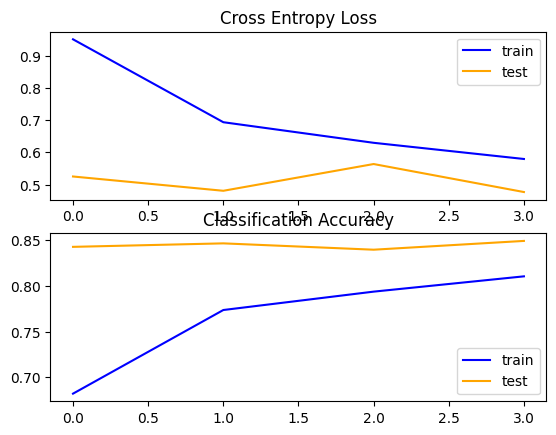

In [ ]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history2['loss'], color='blue', label='train')
plt.plot(history2['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history2['accuracy'], color='blue', label='train')
plt.plot(history2['val_accuracy'], color='orange', label='test')
plt.legend()

plt.show()

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


['./data/test/m0/', './data/test/m1/', './data/test/m2/', './data/test/m3/', './data/test/m4/', './data/test/m5/', './data/test/m6/', './data/test/m7/', './data/test/m8/', './data/test/m9/']
./data/test/m0/
./data/test/m1/
./data/test/m2/
./data/test/m3/
./data/test/m4/
./data/test/m5/
./data/test/m6/
./data/test/m7/
./data/test/m8/
./data/test/m9/


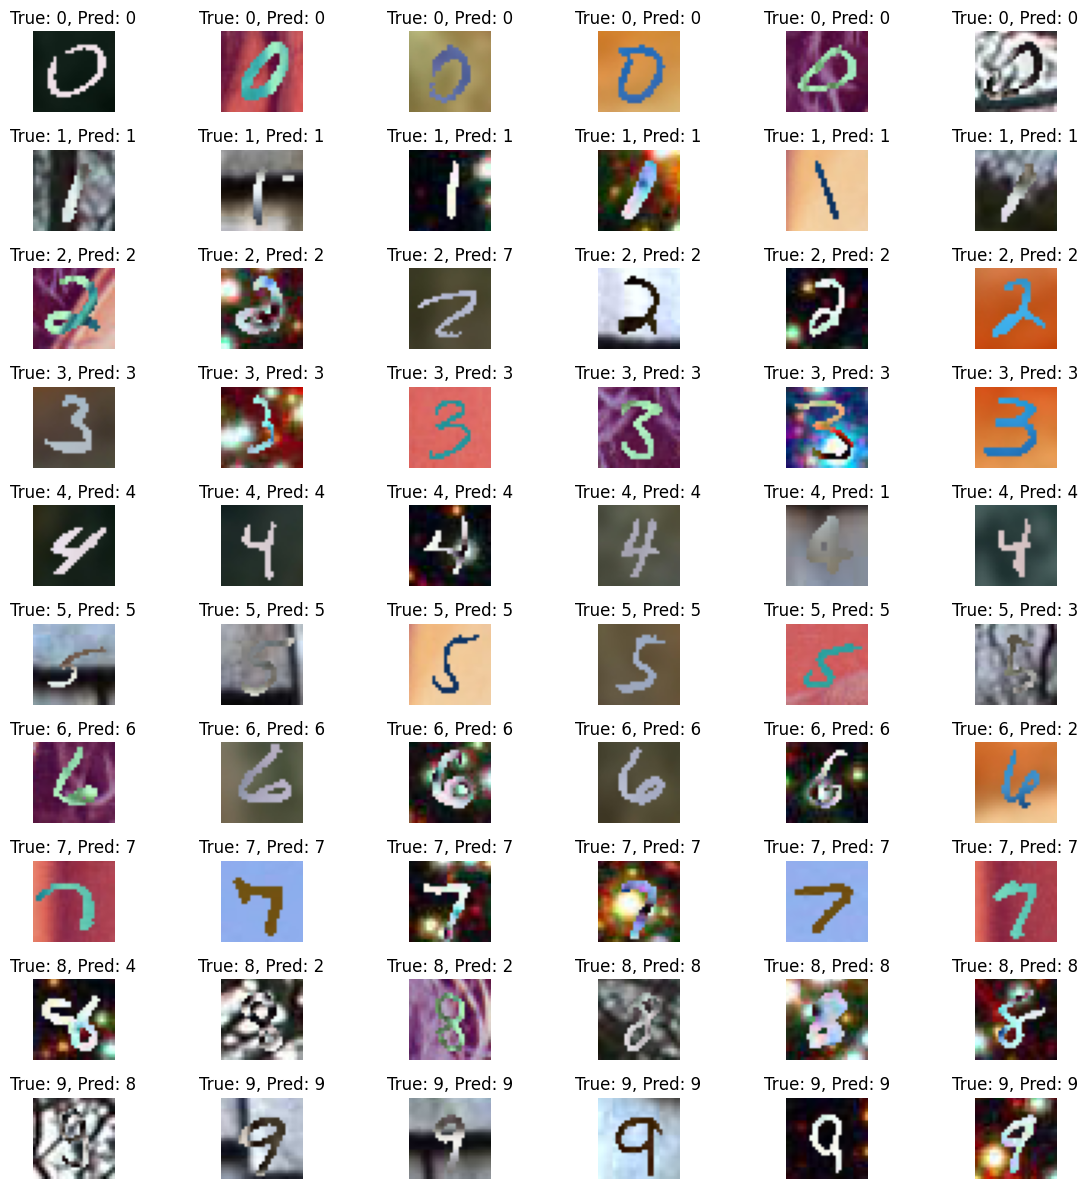

Tested 60 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         6
     Class 1       0.86      1.00      0.92         6
     Class 2       0.62      0.83      0.71         6
     Class 3       0.86      1.00      0.92         6
     Class 4       0.83      0.83      0.83         6
     Class 5       1.00      0.83      0.91         6
     Class 6       1.00      0.83      0.91         6
     Class 7       0.86      1.00      0.92         6
     Class 8       0.75      0.50      0.60         6
     Class 9       1.00      0.83      0.91         6

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.86        60
weighted avg       0.88      0.87      0.86        60

Confusion Matrix:
[[6 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 1 0 0]
 [0 0 0 6 0 0 0 0 0 0]
 [0 1 0 0 5 0 0 0 0 0]
 [0 0 0 1 0 5 0 0 0 0]
 [0 0 1 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 6 0 0]

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from sklearn.metrics import classification_report, confusion_matrix

# Lista de directorios que contienen las imágenes etiquetadas
# Cargar el modelo
model_path = './drive/MyDrive/modelo2.h5'
modelo2 = load_model(model_path)

# Función para recortar la imagen al centro
def crop_center(img, size):
    y, x = img.shape[:2]
    startx = x//2 - (size//2)
    starty = y//2 - (size//2)
    return img[starty:starty+size, startx:startx+size]

# Función para preprocesar una imagen de la misma manera que en el generador de datos
def preprocess_image(image_path, target_size=(200, 200)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Recortar la imagen al centro
    cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

    # Redimensionar la imagen a tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(cropped_img.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después


lala = [folder+subdirs[1] + label for label in labeldirs]
print(lala)

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(lala):
    print(labeldir)
    for root, dirs, files in os.walk(labeldir):
        # Escoger 2 imágenes aleatorias
        filesRandom = random.choices(files, k=6)
        for file in filesRandom:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción
                predictions = modelo2.predict(preprocessed_image, verbose=0)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción

# Mostrar las imágenes con sus predicciones
num_images = len(images)
cols = 6  # número de columnas que deseas
rows = (num_images // cols) + int(num_images % cols > 0)  # calcula el número de filas necesario

plt.figure(figsize=(12, 12))
for i, (img_path, true_label, pred_label) in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imread(img_path))
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


['./data/test/m0/', './data/test/m1/', './data/test/m2/', './data/test/m3/', './data/test/m4/', './data/test/m5/', './data/test/m6/', './data/test/m7/', './data/test/m8/', './data/test/m9/']
./data/test/m0/
./data/test/m1/
./data/test/m2/
./data/test/m3/
./data/test/m4/
./data/test/m5/
./data/test/m6/
./data/test/m7/
./data/test/m8/
./data/test/m9/
Tested 1000 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.90      0.87       100
     Class 1       0.84      0.87      0.86       100
     Class 2       0.87      0.88      0.88       100
     Class 3       0.78      0.88      0.83       100
     Class 4       0.84      0.74      0.79       100
     Class 5       0.87      0.66      0.75       100
     Class 6       0.83      0.95      0.88       100
     Class 7       0.79      0.79      0.79       100
     Class 8       0.86      0.83      0.85       100
     Class 9       0.83      0.83      0.83       100

    accurac

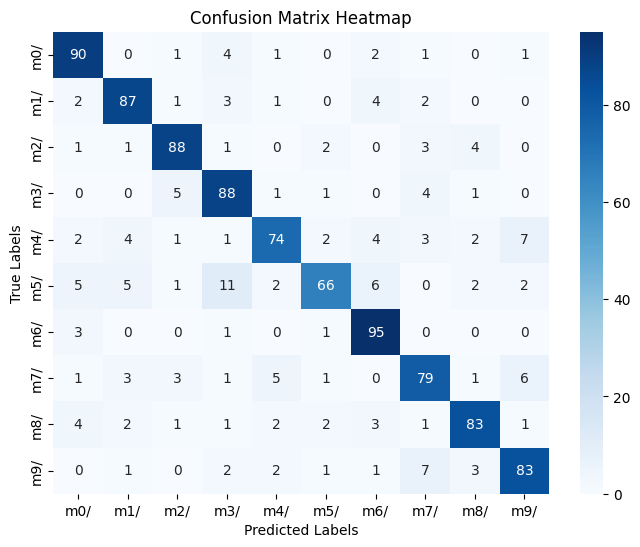

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from sklearn.metrics import classification_report, confusion_matrix

# Lista de directorios que contienen las imágenes etiquetadas
# Cargar el modelo
model_path = './drive/MyDrive/modelo2.h5'
modelo2 = load_model(model_path)

# Función para recortar la imagen al centro
def crop_center(img, size):
    y, x = img.shape[:2]
    startx = x//2 - (size//2)
    starty = y//2 - (size//2)
    return img[starty:starty+size, startx:startx+size]

# Función para preprocesar una imagen de la misma manera que en el generador de datos
def preprocess_image(image_path, target_size=(200, 200)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Recortar la imagen al centro
    cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

    # Redimensionar la imagen a tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(cropped_img.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después


lala = [folder+subdirs[1] + label for label in labeldirs]
print(lala)

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(lala):
    print(labeldir)
    for root, dirs, files in os.walk(labeldir):
        # Escoger 2 imágenes aleatorias
        filesRandom = random.choices(files, k=100)
        for file in filesRandom:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción
                predictions = modelo2.predict(preprocessed_image, verbose=0)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción


# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Hacemos el modelo de redes neuronales simples


In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from tensorflow import keras
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from skimage.io import imread
from skimage.color import rgb2gray
import cv2  # OpenCV para redimensionar imágenes


# Asignar etiquetas a cada clase
binary_label_map = {
    'm0/': 0,
    'm1/': 1,
    'm2/': 2,
    'm3/': 3,
    'm4/': 4,
    'm5/': 5,
    'm6/': 6,
    'm7/': 7,
    'm8/': 8,
    'm9/': 9
}

def crop_center(image, crop_size):
    center = tuple(map(lambda x: x // 2, image.shape))
    half_crop = crop_size // 2
    return image[center[0] - half_crop:center[0] + half_crop,
                 center[1] - half_crop:center[1] + half_crop]

class ImageDataGenerator(Sequence):
    def __init__(self, directory, labeldirs, label_map, batch_size=32, target_size=(200, 200), shuffle=True):
        self.directory = directory
        self.labeldirs = labeldirs
        self.label_map = label_map
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_paths, self.labels = self._load_image_paths_and_labels()
        self.on_epoch_end()

    def _load_image_paths_and_labels(self):
        image_paths = []
        labels = []
        for dir in self.labeldirs:
            dir_path = os.path.join(self.directory, dir)
            for file in os.listdir(dir_path):
                img_path = os.path.join(dir_path, file)
                image_paths.append(img_path)
                labels.append(self.label_map[dir])
        return image_paths, labels

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_image_paths = self.image_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        for img_path in batch_image_paths:
            img = imread(img_path)
            img_gray = rgb2gray(img)  # Convertir a escala de grises

            # Invertir los colores
            img_inverted = 1 - img_gray

            # Aplicar umbral Otsu
            thresh = threshold_otsu(img_inverted)
            binary_img = img_inverted > thresh

            # Aplicar suavizado ligero
            img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

            # Aplicar detección de bordes
            edges = canny(img_smoothed, sigma=1.0)

            # Superponer bordes sobre la imagen binaria
            processed_img = np.clip(binary_img + edges, 0, 1)

            # Realzar el contraste
            processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

            # Recortar la imagen al centro
            cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

            # Redimensionar la imagen a tamaño objetivo usando OpenCV
            processed_img_resized = cv2.resize(cropped_img.astype(np.float32), self.target_size, interpolation=cv2.INTER_AREA)

            # Asegurar que la imagen tenga 3 canales (RGB) y agregar al lote
            if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
                processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

            images.append(processed_img_resized)

        return np.array(images), np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            indices = np.arange(len(self.image_paths))
            np.random.shuffle(indices)
            self.image_paths = np.array(self.image_paths)[indices]
            self.labels = np.array(self.labels)[indices]

# Crear instancias del generador de datos
train_generator = ImageDataGenerator(os.path.join(folder, subdirs[0]), labeldirs, binary_label_map, batch_size=32)
test_generator = ImageDataGenerator(os.path.join(folder, subdirs[1]), labeldirs, binary_label_map, batch_size=32)

# Definir el modelo simple
modelo3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(200, 200, 3)),  # Aplanar la imagen
    keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.5),  # Dropout para reducir el sobreajuste
    keras.layers.Dense(10, activation='softmax')
])

# Compilar el modelo
opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
modelo3.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo
modelo3.summary()

# Definir EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Puedes cambiar esto a 'val_accuracy' si prefieres monitorear la precisión
    patience=5,           # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True
)

# Entrenar el modelo
history = modelo3.fit(
    train_generator,
    validation_data=test_generator,
    epochs=4,  # Puedes ajustar el número de épocas
    callbacks=[early_stopping]
)

import json
history_path = 'history3.json'
model_save_path = 'modelo3.h5'
modelo3.save(model_save_path)
print(f'Modelo guardado en {model_save_path}')

with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f'Historial guardado en {history_path}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 120000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      15,360,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,361,418 (58.60 MB)

 Trainable params: 15,361,418 (58.60 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9375/9375 ━━━━━━━━━━━━━━━━━━━━ 5318s 567ms/step - accuracy: 0.1131 - loss: 2.4892 - val_accuracy: 0.1135 - val_loss: 2.2941
Epoch 2/4
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 5291s 564ms/step - accuracy: 0.1138 - loss: 2.2864 - val_accuracy: 0.1185 - val_loss: 2.2688
Epoch 3/4
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 5250s 559ms/step - accuracy: 0.1117 - loss: 2.2863 - val_accuracy: 0.1203 - val_loss: 2.2660
Epoch 4/4
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 4874s 519ms/step - accuracy: 0.1120 - loss: 2.2884 - val_accuracy: 0.1135 - val_loss: 2.2701


Modelo guardado en modelo3.h5
Historial guardado en history3.json


In [ ]:
# Cargar el modelo (opcional)
from tensorflow.keras.models import load_model
modelo3 = load_model(model_save_path)
print('Modelo cargado exitosamente.')
# Recompilar el modelo para tener métricas actualizadas
modelo3.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Realizar una evaluación (opcional)
loss, accuracy = modelo3.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss:.4f}')
print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')

with open(history_path, 'r') as f:
    history3 = json.load(f)

Modelo cargado exitosamente.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 565s 361ms/step - accuracy: 0.1200 - loss: 2.2656
Pérdida en el conjunto de prueba: 2.2659
Precisión en el conjunto de prueba: 0.1204


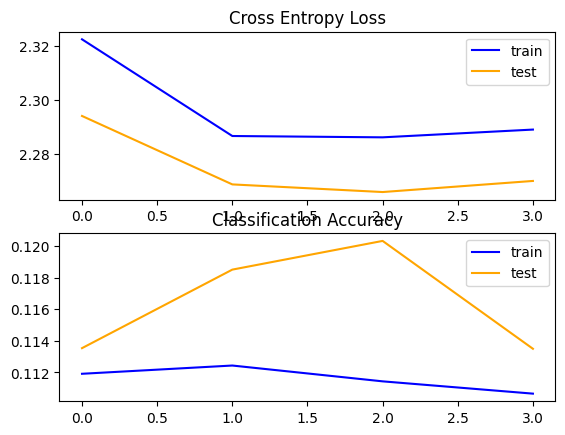

In [ ]:
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history3['loss'], color='blue', label='train')
plt.plot(history3['val_loss'], color='orange', label='test')
plt.legend()
 # plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history3['accuracy'], color='blue', label='train')
plt.plot(history3['val_accuracy'], color='orange', label='test')
plt.legend()

plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


['./data/test/m0/', './data/test/m1/', './data/test/m2/', './data/test/m3/', './data/test/m4/', './data/test/m5/', './data/test/m6/', './data/test/m7/', './data/test/m8/', './data/test/m9/']
./data/test/m0/
./data/test/m1/
./data/test/m2/
./data/test/m3/
./data/test/m4/
./data/test/m5/
./data/test/m6/
./data/test/m7/
./data/test/m8/
./data/test/m9/


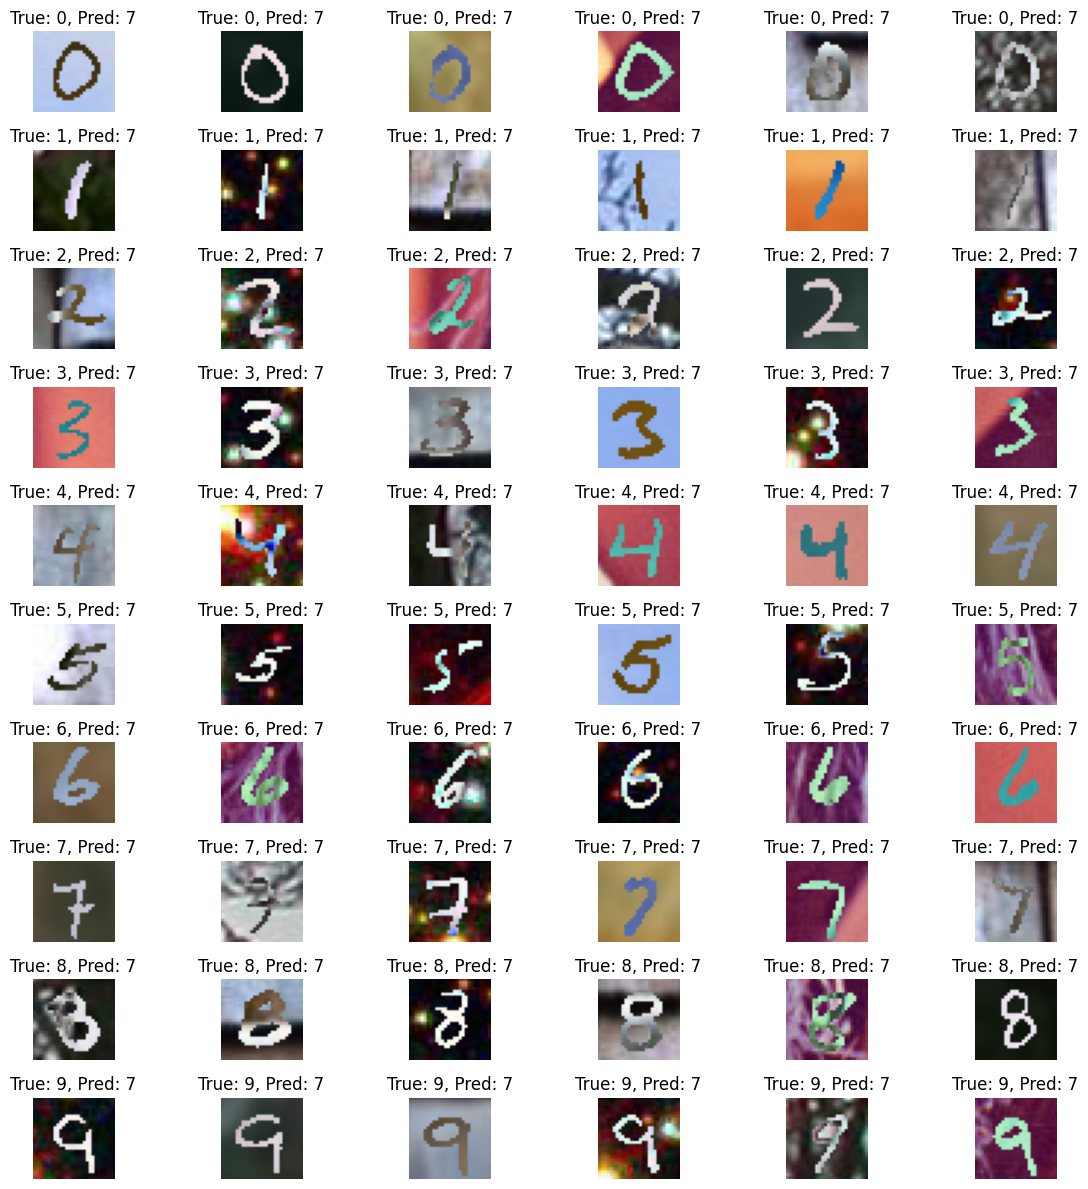

Tested 60 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         6
     Class 1       0.00      0.00      0.00         6
     Class 2       0.00      0.00      0.00         6
     Class 3       0.00      0.00      0.00         6
     Class 4       0.00      0.00      0.00         6
     Class 5       0.00      0.00      0.00         6
     Class 6       0.00      0.00      0.00         6
     Class 7       0.10      1.00      0.18         6
     Class 8       0.00      0.00      0.00         6
     Class 9       0.00      0.00      0.00         6

    accuracy                           0.10        60
   macro avg       0.01      0.10      0.02        60
weighted avg       0.01      0.10      0.02        60

Confusion Matrix:
[[0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 6 0 0]
 [0 0 0 0 0 0 0 6 0 0]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


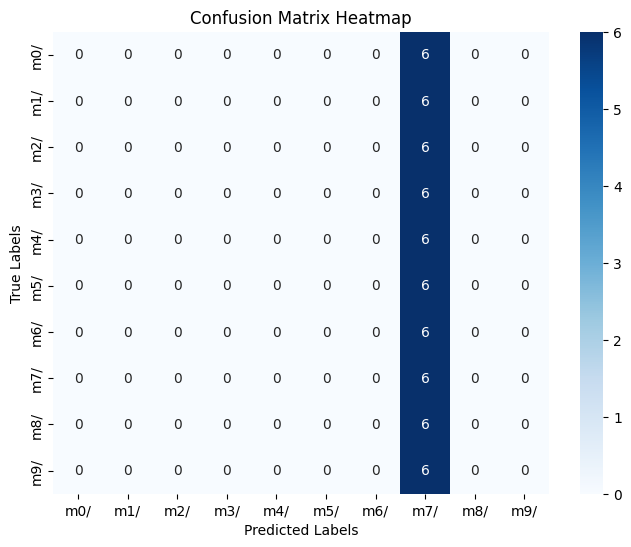

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from sklearn.metrics import classification_report, confusion_matrix

# Lista de directorios que contienen las imágenes etiquetadas
# Cargar el modelo
model_path = './modelo3.h5'
modelo3 = load_model(model_path)

# Función para recortar la imagen al centro
def crop_center(img, size):
    y, x = img.shape[:2]
    startx = x//2 - (size//2)
    starty = y//2 - (size//2)
    return img[starty:starty+size, startx:startx+size]

# Función para preprocesar una imagen de la misma manera que en el generador de datos
def preprocess_image(image_path, target_size=(200, 200)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Recortar la imagen al centro
    cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

    # Redimensionar la imagen a tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(cropped_img.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después


lala = [folder+subdirs[1] + label for label in labeldirs]
print(lala)

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(lala):
    print(labeldir)
    for root, dirs, files in os.walk(labeldir):
        # Escoger 2 imágenes aleatorias
        filesRandom = random.choices(files, k=6)
        for file in filesRandom:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción
                predictions = modelo3.predict(preprocessed_image, verbose=0)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción

# Mostrar las imágenes con sus predicciones
num_images = len(images)
cols = 6  # número de columnas que deseas
rows = (num_images // cols) + int(num_images % cols > 0)  # calcula el número de filas necesario

plt.figure(figsize=(12, 12))
for i, (img_path, true_label, pred_label) in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imread(img_path))
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


['./data/test/m0/', './data/test/m1/', './data/test/m2/', './data/test/m3/', './data/test/m4/', './data/test/m5/', './data/test/m6/', './data/test/m7/', './data/test/m8/', './data/test/m9/']
./data/test/m0/
./data/test/m1/
./data/test/m2/
./data/test/m3/
./data/test/m4/
./data/test/m5/
./data/test/m6/
./data/test/m7/
./data/test/m8/
./data/test/m9/
Tested 1000 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00       100
     Class 1       0.81      0.21      0.33       100
     Class 2       0.00      0.00      0.00       100
     Class 3       0.00      0.00      0.00       100
     Class 4       0.00      0.00      0.00       100
     Class 5       0.00      0.00      0.00       100
     Class 6       0.00      0.00      0.00       100
     Class 7       0.10      0.98      0.18       100
     Class 8       0.00      0.00      0.00       100
     Class 9       0.00      0.00      0.00       100

    accurac

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


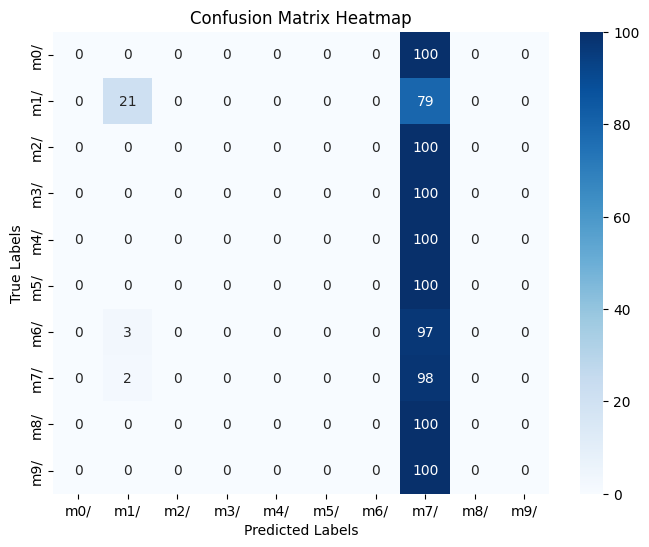

In [ ]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from sklearn.metrics import classification_report, confusion_matrix

# Lista de directorios que contienen las imágenes etiquetadas
# Cargar el modelo
model_path = './modelo3.h5'
modelo3 = load_model(model_path)

# Función para recortar la imagen al centro
def crop_center(img, size):
    y, x = img.shape[:2]
    startx = x//2 - (size//2)
    starty = y//2 - (size//2)
    return img[starty:starty+size, startx:startx+size]

# Función para preprocesar una imagen de la misma manera que en el generador de datos
def preprocess_image(image_path, target_size=(200, 200)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Recortar la imagen al centro
    cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

    # Redimensionar la imagen a tamaño objetivo usando OpenCV
    processed_img_resized = cv2.resize(cropped_img.astype(np.float32), target_size, interpolation=cv2.INTER_AREA)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img_resized.shape) == 2:  # Imagen en escala de grises
        processed_img_resized = np.stack([processed_img_resized] * 3, axis=-1)

    return processed_img_resized

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después


lala = [folder+subdirs[1] + label for label in labeldirs]
print(lala)

# Recorrer todas las carpetas y predecir cada imagen
for label_index, labeldir in enumerate(lala):
    print(labeldir)
    for root, dirs, files in os.walk(labeldir):
        # Escoger 2 imágenes aleatorias
        filesRandom = random.choices(files, k=100)
        for file in filesRandom:
            if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
                image_path = os.path.join(root, file)
                preprocessed_image = preprocess_image(image_path)
                preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

                # Realizar predicción
                predictions = modelo3.predict(preprocessed_image, verbose=0)
                predicted_class = np.argmax(predictions, axis=1)[0]

                # Guardar la etiqueta verdadera y la predicción
                y_true.append(label_index)
                y_pred.append(predicted_class)
                images.append((image_path, label_index, predicted_class))  # Guardar la imagen y su predicción

# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(labeldirs))]))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


### Hacemos el modelo de knn pero usando las imagenes con el filtro.

/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:50:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:50:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:51:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA in

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.87      0.90      0.89      4900
     Class 1       0.88      0.89      0.89      5675
     Class 2       0.86      0.85      0.86      5160
     Class 3       0.85      0.86      0.86      5050
     Class 4       0.87      0.85      0.86      4910
     Class 5       0.87      0.84      0.85      4460
     Class 6       0.88      0.89      0.89      4790
     Class 7       0.85      0.85      0.85      5140
     Class 8       0.84      0.82      0.83      4870
     Class 9       0.82      0.83      0.82      5045

    accuracy                           0.86     50000
   macro avg       0.86      0.86      0.86     50000
weighted avg       0.86      0.86      0.86     50000

Confusion Matrix:
[[4416   25   53   57   26   45  105   40   87   46]
 [  47 5076  103   53   80   31   66   79  109   31]
 [ 104   96 4397  142   53   24   69  107  113   55]
 [  66   47  107 4335   31  176   39   74

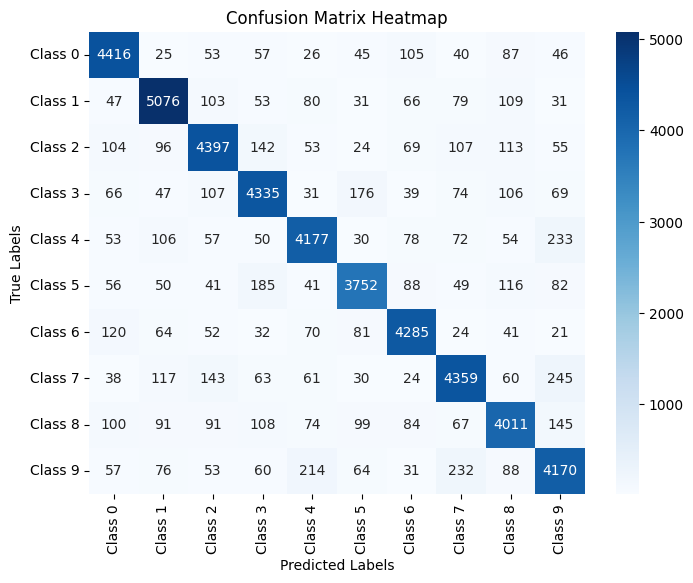

Modelo XGBoost guardado en modelo_xgb.pkl
Historial del modelo XGBoost guardado en history_xgb.json


In [7]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import joblib  # Para guardar el modelo
import json
import seaborn as sns
import matplotlib.pyplot as plt

def crop_center(image, crop_size):
    center = tuple(map(lambda x: x // 2, image.shape))
    half_crop = crop_size // 2
    return image[center[0] - half_crop:center[0] + half_crop,
                 center[1] - half_crop:center[1] + half_crop]

def preprocess_image(image_path):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)  # Ajustar sigma si es necesario

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste (opcional)
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Recortar la imagen al centro
    cropped_img = crop_center(processed_img, 28)  # Asumiendo que quieres el tamaño 28x28

    return cropped_img.flatten()

# Asignar etiquetas a cada clase
binary_label_map = {
    'm0/': 0,
    'm1/': 1,
    'm2/': 2,
    'm3/': 3,
    'm4/': 4,
    'm5/': 5,
    'm6/': 6,
    'm7/': 7,
    'm8/': 8,
    'm9/': 9
}

def load_data(directory, labeldirs, label_map):
    image_paths = []
    labels = []
    for dir in labeldirs:
        dir_path = os.path.join(directory, dir)
        for file in os.listdir(dir_path):
            img_path = os.path.join(dir_path, file)
            image_paths.append(img_path)
            labels.append(label_map[dir])
    return image_paths, labels


train_image_paths, train_labels = load_data(os.path.join(folder, subdirs[0]), labeldirs, binary_label_map)
test_image_paths, test_labels = load_data(os.path.join(folder, subdirs[1]), labeldirs, binary_label_map)

# Cargar y procesar imágenes
X_train = np.array([preprocess_image(img_path) for img_path in train_image_paths])
y_train = np.array(train_labels)

X_test = np.array([preprocess_image(img_path) for img_path in test_image_paths])
y_test = np.array(test_labels)

# Definir el clasificador XGBoost
model = xgb.XGBClassifier(tree_method='gpu_hist', use_label_encoder=False)

# Entrenar el modelo
model.fit(X_train, y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(len(binary_label_map))]))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(len(binary_label_map))], yticklabels=[f'Class {i}' for i in range(len(binary_label_map))])

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Guardar el modelo y el historial
model_save_path_xgb = 'modelo_xgb.pkl'
history_path_xgb = 'history_xgb.json'

# Guardar el modelo XGBoost
joblib.dump(model, model_save_path_xgb)
print(f'Modelo XGBoost guardado en {model_save_path_xgb}')

# Guardar el historial de evaluación del modelo
history = {
    'classification_report': classification_report(y_test, y_pred, output_dict=True),
    'confusion_matrix': cm.tolist()
}

with open(history_path_xgb, 'w') as f:
    json.dump(history, f)
print(f'Historial del modelo XGBoost guardado en {history_path_xgb}')


### Probando el mejor modelo con digitos a mano

In [9]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


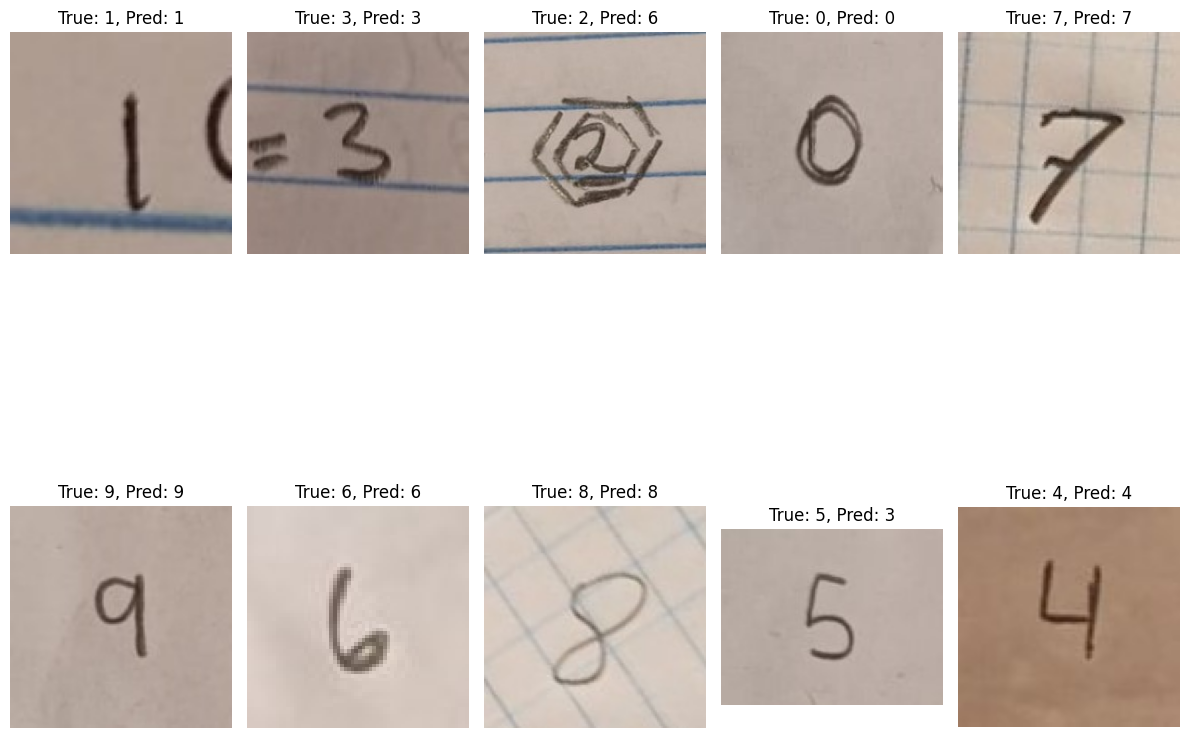

Tested 10 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         1
     Class 1       1.00      1.00      1.00         1
     Class 2       0.00      0.00      0.00         1
     Class 3       0.50      1.00      0.67         1
     Class 4       1.00      1.00      1.00         1
     Class 5       0.00      0.00      0.00         1
     Class 6       0.50      1.00      0.67         1
     Class 7       1.00      1.00      1.00         1
     Class 8       1.00      1.00      1.00         1
     Class 9       1.00      1.00      1.00         1

    accuracy                           0.80        10
   macro avg       0.70      0.80      0.73        10
weighted avg       0.70      0.80      0.73        10

Confusion Matrix:
[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


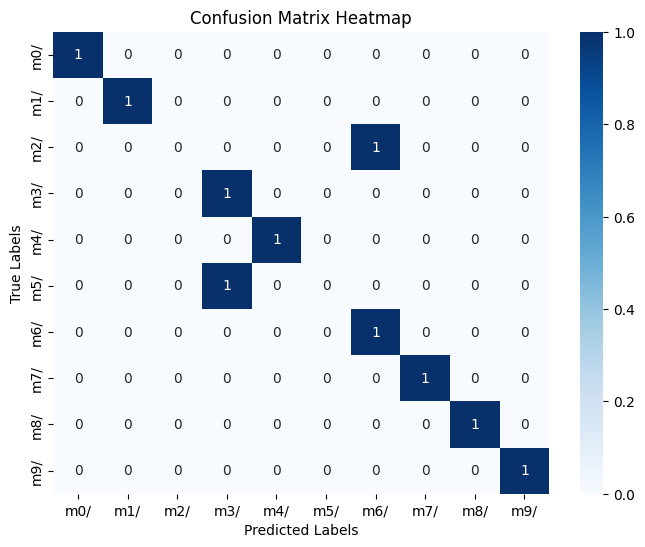

In [42]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
from sklearn.metrics import classification_report, confusion_matrix

# Cargar el modelo
model_path = './drive/MyDrive/modelo2.h5'
modelo2 = load_model(model_path)

def preprocess_image(image_path, target_size=(200, 200)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)  # Suavizado más ligero para preservar bordes

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Redimensionar la imagen al tamaño esperado por el modelo
    processed_img = cv2.resize(processed_img, target_size)

    # Asegurar que la imagen tenga 3 canales (RGB)
    if len(processed_img.shape) == 2:  # Imagen en escala de grises
        processed_img = np.stack([processed_img] * 3, axis=-1)

    return processed_img

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después

# Ruta de la carpeta que contiene las imágenes
folder = 'adasd'

# Recorrer las imágenes en la carpeta 'adasd'
for file in os.listdir(folder):
    if file.endswith(('.jpg', '.png', '.jpeg')):  # Asegúrate de incluir las extensiones correctas
        image_path = os.path.join(folder, file)
        true_label = int(os.path.splitext(file)[0])  # Obtener la etiqueta verdadera del nombre del archivo
        preprocessed_image = preprocess_image(image_path)
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

        # Realizar predicción
        predictions = modelo2.predict(preprocessed_image, verbose=0)
        predicted_class = np.argmax(predictions, axis=1)[0]

        # Guardar la etiqueta verdadera y la predicción
        y_true.append(true_label)
        y_pred.append(predicted_class)
        images.append((image_path, true_label, predicted_class))  # Guardar la imagen y su predicción

# Mostrar las imágenes con sus predicciones
num_images = len(images)
cols = 5  # Número de columnas que deseas
rows = (num_images // cols) + int(num_images % cols > 0)  # Calcula el número de filas necesario

plt.figure(figsize=(12, 12))
for i, (img_path, true_label, pred_label) in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imread(img_path))
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
# Suponiendo que tienes 10 clases, actualiza target_names para que tenga 10 etiquetas
target_names = [f'Class {i}' for i in range(10)]  # Cambia '10' por el número real de clases si es diferente

# Imprimir el informe de clasificación
print(classification_report(y_true, y_pred, target_names=target_names))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))



import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Crear un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labeldirs, yticklabels=labeldirs)

# Configurar los títulos y etiquetas
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:14:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


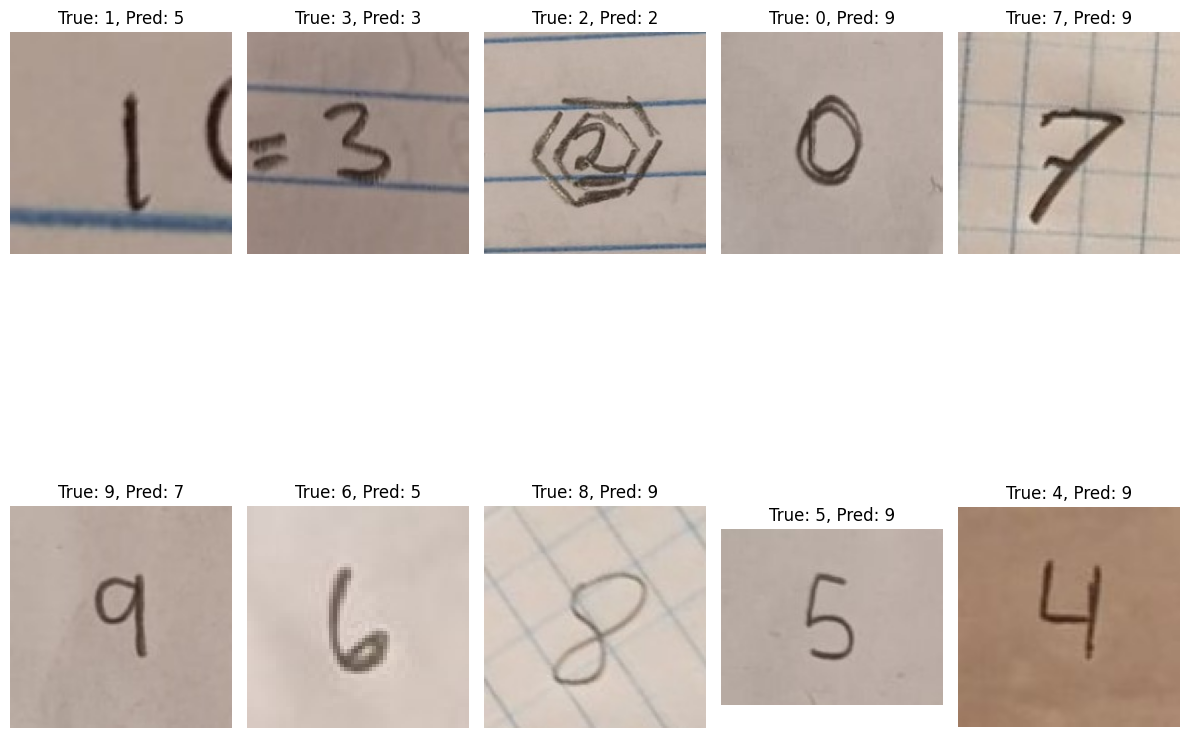

Tested 10 images
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         1
     Class 1       0.00      0.00      0.00         1
     Class 2       1.00      1.00      1.00         1
     Class 3       1.00      1.00      1.00         1
     Class 4       0.00      0.00      0.00         1
     Class 5       0.00      0.00      0.00         1
     Class 6       0.00      0.00      0.00         1
     Class 7       0.00      0.00      0.00         1
     Class 8       0.00      0.00      0.00         1
     Class 9       0.00      0.00      0.00         1

    accuracy                           0.20        10
   macro avg       0.20      0.20      0.20        10
weighted avg       0.20      0.20      0.20        10

Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


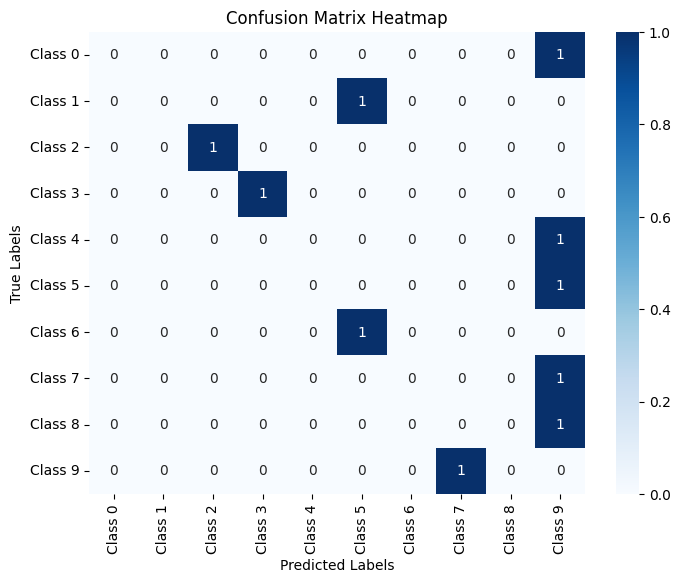

In [43]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import cv2  # Para redimensionar imágenes

# Cargar el modelo
model_path = 'modelo_xgb.pkl'
modelo_xgb = joblib.load(model_path)

def preprocess_image(image_path, target_size=(28, 28)):  # Cambié el tamaño a 28x28
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Redimensionar la imagen al tamaño esperado por el modelo (28x28)
    processed_img = cv2.resize(processed_img, target_size)

    return processed_img.flatten()

# Preparar listas para las predicciones y etiquetas reales
y_true = []
y_pred = []
images = []  # Lista para guardar las imágenes y mostrarlas después

# Ruta de la carpeta que contiene las imágenes
folder = 'adasd'

# Recorrer las imágenes en la carpeta 'adasd'
for file in os.listdir(folder):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(folder, file)
        true_label = int(os.path.splitext(file)[0])  # Obtener la etiqueta verdadera del nombre del archivo
        preprocessed_image = preprocess_image(image_path)
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)  # Añadir dimensión de lote

        # Realizar predicción con el modelo XGBoost
        predicted_class = modelo_xgb.predict(preprocessed_image)[0]

        # Guardar la etiqueta verdadera y la predicción
        y_true.append(true_label)
        y_pred.append(predicted_class)
        images.append((image_path, true_label, predicted_class))

# Mostrar las imágenes con sus predicciones
num_images = len(images)
cols = 5
rows = (num_images // cols) + int(num_images % cols > 0)

plt.figure(figsize=(12, 12))
for i, (img_path, true_label, pred_label) in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imread(img_path))
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Evaluar el rendimiento del modelo
print(f"Tested {len(images)} images")
print("Classification Report:")
target_names = [f'Class {i}' for i in range(10)]

print(classification_report(y_true, y_pred, target_names=target_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Crear un mapa de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:527: UserWarning: Downcasting int64 to uint16 without scaling because max value 1 fits in uint16
  return _convert(image, np.uint16, force_copy)


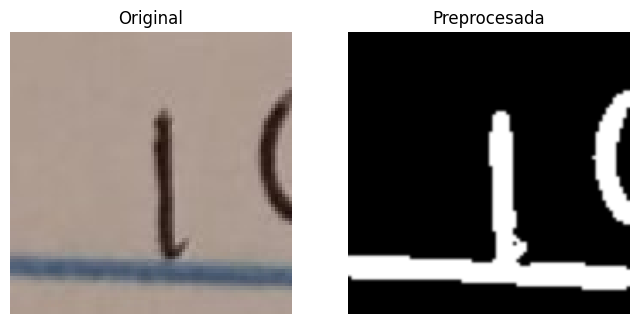

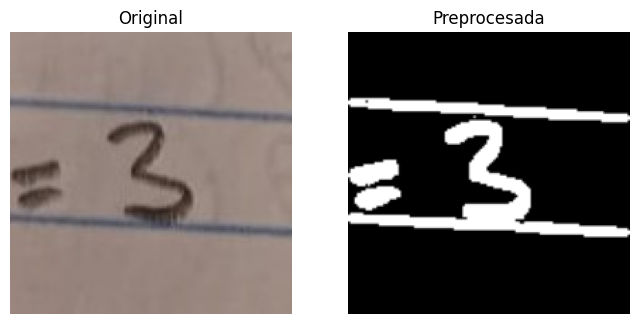

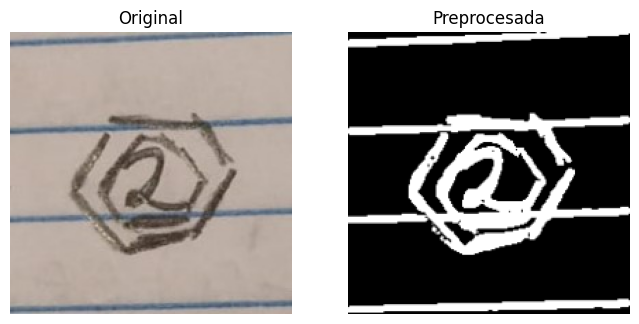

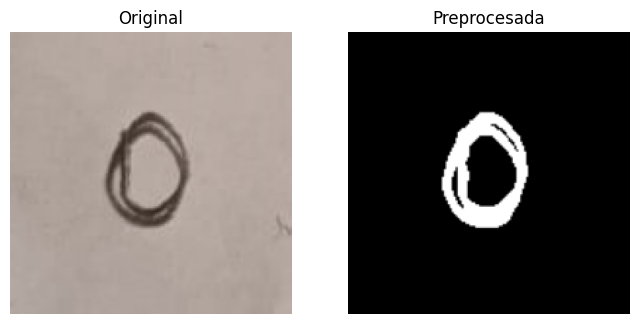

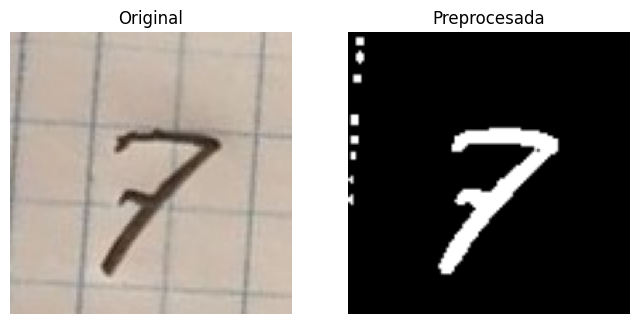

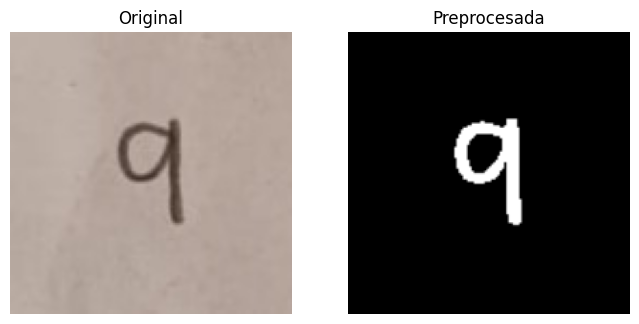

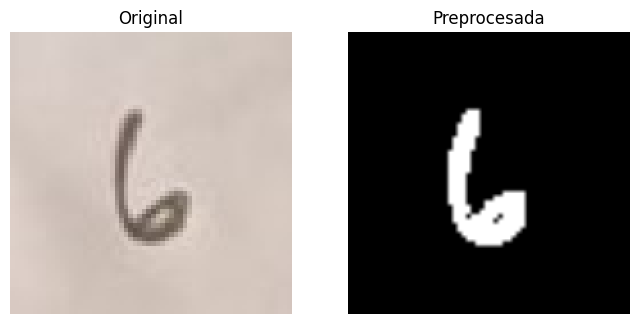

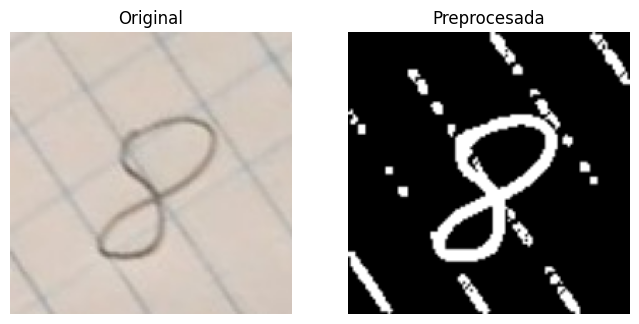

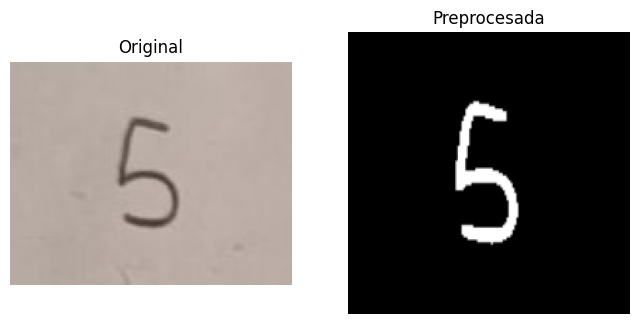

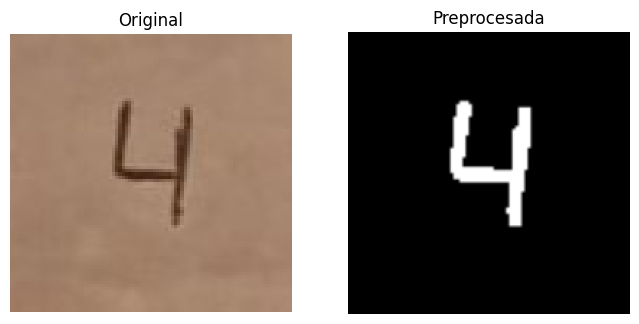

In [44]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, gaussian
from skimage.feature import canny
from skimage import exposure
import matplotlib.pyplot as plt
import cv2  # Para redimensionar imágenes

def preprocess_image(image_path, target_size=(200, 200)):
    img = imread(image_path)
    img_gray = rgb2gray(img)  # Convertir a escala de grises

    # Invertir los colores
    img_inverted = 1 - img_gray

    # Aplicar umbral Otsu
    thresh = threshold_otsu(img_inverted)
    binary_img = img_inverted > thresh

    # Aplicar suavizado ligero
    img_smoothed = gaussian(binary_img, sigma=0.5)

    # Aplicar detección de bordes
    edges = canny(img_smoothed, sigma=1.0)

    # Superponer bordes sobre la imagen binaria
    processed_img = np.clip(binary_img + edges, 0, 1)

    # Realzar el contraste
    processed_img = exposure.equalize_adapthist(processed_img, clip_limit=0.02)

    # Redimensionar la imagen al tamaño esperado por el modelo (28x28)
    processed_img = cv2.resize(processed_img, target_size)

    return processed_img

# Ruta de la carpeta que contiene las imágenes
folder = 'adasd'

# Recorrer las imágenes en la carpeta 'adasd'
for file in os.listdir(folder):
    if file.endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(folder, file)
        preprocessed_image = preprocess_image(image_path)

        # Mostrar la imagen original y la preprocesada
        original_img = imread(image_path)

        plt.figure(figsize=(8, 4))

        # Imagen original
        plt.subplot(1, 2, 1)
        plt.imshow(original_img, cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Imagen preprocesada
        plt.subplot(1, 2, 2)
        plt.imshow(preprocessed_image, cmap='gray')
        plt.title("Preprocesada")
        plt.axis('off')

        plt.show()
